# Preprocessing of given dataset

Analysed data is "Air passenger transport between the main airports of Poland and their main partner airports" from Eurostat database.

Source: https://ec.europa.eu/eurostat/web/transport/data/database [31/01/2020]

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('airplane_data.csv')
df.head()

,TIME,AIRP_PR,TRA_MEAS,UNIT,Value
0,2004M01,BYDGOSZCZ/SZWEDEROWO airport - BURGAS airport,Passengers on board,Passenger,:
1,2004M01,BYDGOSZCZ/SZWEDEROWO airport - BURGAS airport,Passengers on board,Flight,:
2,2004M01,BYDGOSZCZ/SZWEDEROWO airport - BURGAS airport,Commercial passenger air flights,Passenger,:
3,2004M01,BYDGOSZCZ/SZWEDEROWO airport - BURGAS airport,Commercial passenger air flights,Flight,:
4,2004M01,BYDGOSZCZ/SZWEDEROWO airport - FRANKFURT/MAIN ...,Passengers on board,Passenger,:


Meaning of columns:
- TIME is the given month, 
- AIRP_PR is airplane route, 
- TRA_MEAS is the measure of UNIT and 
- VALUE is the number of passengers or flights on given route during one month. The symbol ':' means that the is no data in this record.

At this moment there is only default index. Moreover, AIRP_PR should be split into two columns - the mother airport and the destination in the future analysis. But the next step is to check the detailed info about the data.

In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394632 entries, 0 to 394631
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   TIME      394632 non-null  object
 1   AIRP_PR   394632 non-null  object
 2   TRA_MEAS  394632 non-null  object
 3   UNIT      394632 non-null  object
 4   Value     394632 non-null  object
dtypes: object(5)
memory usage: 141.4 MB


The data contains 394,632 rows and 5 columns.
Dtypes of every column is 'object', hence the memory usage is significant (141 MB). In order to optimize the analysis process I need to change dtypes of data in columns. 

Checking the number of unique values and changing *dtype* to category of those columns that has low number of unique values.

In [4]:
df.nunique()

TIME          189
AIRP_PR       522
TRA_MEAS        2
UNIT            2
Value       16046
dtype: int64

In [5]:
df['UNIT'] = df['UNIT'].astype('category')
df['TRA_MEAS'] = df['TRA_MEAS'].astype('category')

Checking the number of missing values.

In [6]:
df.isnull().sum()

TIME        0
AIRP_PR     0
TRA_MEAS    0
UNIT        0
Value       0
dtype: int64

There is no missing values in (as np.nan) in the dataset. But you can see that in case of no values Eurostat uses the colon sign. In order to change Values column to integer (or float in this case) I need to change ":" to np.nan and remove whitespace between the numbers to they can be interpreted as number, not string.

In [7]:
#changing colon to np.nan
df['Value'].replace(':', np.nan, inplace=True)
#changing object dtype to actual float number
df['Value'] = df['Value'].str.replace(' ','')
df['Value'] = df['Value'].astype('float')

Changing *dtype* of TIME column to datetime in order to be able to analyse dates.

In [8]:
df['TIME'] = df['TIME'].apply(lambda time: '-'.join(time.split('M')))
df['TIME'] = pd.to_datetime(df['TIME'])

Memory usage after initial optimization has been reduced threefold, which will improve the analysis process.

In [9]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394632 entries, 0 to 394631
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   TIME      394632 non-null  datetime64[ns]
 1   AIRP_PR   394632 non-null  object        
 2   TRA_MEAS  394632 non-null  category      
 3   UNIT      394632 non-null  category      
 4   Value     67891 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(1)
memory usage: 46.8 MB


The AIRP_PR column, which indicates the route of the aircraft, is difficult to analyse in its current form.

In order to improve analytical capabilities of this dataset, the column containing data specifying the flight connection will be broken down into two separate columns - Departure and Arrival airport.

In [10]:
#In some cases there are more than one dash in connection name. Bearing this in mind, 
#'AIRP_PR' column will be broken down by 'airport -' phrase. In this case it can be sure that
#it will create only two column. Finally, the word 'airport' is removed from the second new column.
df[['Departure', 'Arrival']] = df['AIRP_PR'].str.split(' airport - ', expand=True)
df['Arrival'] = df['Arrival'].apply(lambda x: x.replace(' airport', ''))

df.head()

,TIME,AIRP_PR,TRA_MEAS,UNIT,Value,Departure,Arrival
0,2004-01-01,BYDGOSZCZ/SZWEDEROWO airport - BURGAS airport,Passengers on board,Passenger,NaN,BYDGOSZCZ/SZWEDEROWO,BURGAS
1,2004-01-01,BYDGOSZCZ/SZWEDEROWO airport - BURGAS airport,Passengers on board,Flight,NaN,BYDGOSZCZ/SZWEDEROWO,BURGAS
2,2004-01-01,BYDGOSZCZ/SZWEDEROWO airport - BURGAS airport,Commercial passenger air flights,Passenger,NaN,BYDGOSZCZ/SZWEDEROWO,BURGAS
3,2004-01-01,BYDGOSZCZ/SZWEDEROWO airport - BURGAS airport,Commercial passenger air flights,Flight,NaN,BYDGOSZCZ/SZWEDEROWO,BURGAS
4,2004-01-01,BYDGOSZCZ/SZWEDEROWO airport - FRANKFURT/MAIN ...,Passengers on board,Passenger,NaN,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN


Removal of the previous AIRP_PR column and reordering.

In [11]:
df.drop('AIRP_PR', axis=1, inplace=True)
df = df[['TIME','Departure', 'Arrival', 'TRA_MEAS', 'UNIT', 'Value']]

In [12]:
df.nunique()

TIME           189
Departure       12
Arrival        164
TRA_MEAS         2
UNIT             2
Value        16045
dtype: int64

Splitting AIRP_PR column created new ones with the names of airports. These names repeat multiple times in the dataset (12 and 155), so similarly as above their *dtype* is changed to category.

In [13]:
df['Departure'] = df['Departure'].astype('category')
df['Arrival'] = df['Arrival'].astype('category')

In [14]:
new_column_names = ['Period', 'Departure', 'Arrival', 'Measure', 'Unit', 'Value']
df.columns = new_column_names
df.head()

,Period,Departure,Arrival,Measure,Unit,Value
0,2004-01-01,BYDGOSZCZ/SZWEDEROWO,BURGAS,Passengers on board,Passenger,NaN
1,2004-01-01,BYDGOSZCZ/SZWEDEROWO,BURGAS,Passengers on board,Flight,NaN
2,2004-01-01,BYDGOSZCZ/SZWEDEROWO,BURGAS,Commercial passenger air flights,Passenger,NaN
3,2004-01-01,BYDGOSZCZ/SZWEDEROWO,BURGAS,Commercial passenger air flights,Flight,NaN
4,2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,Passengers on board,Passenger,NaN


Early data analysis indicates that the above data is constructed in such way that there is a separate row for each single case. That means that generated the data unnecessarily contains lines that attempt to indicate the number of passengers in the flight values and the number of flights in the passenger values. In such lines, Value is always equals to np.nan, and the data itself is unnecessarily doubled.

The first step is to create filters that will be used to filter the rows to delete. Next, those filtered rows will be removed from the dataset.

In [15]:
#creating filters to find unnecessary rows
measure_flights = df['Measure'] == 'Commercial passenger air flights'
measure_passengers = df['Measure'] == 'Passengers on board'
unit_flights = df['Unit'] == 'Flight'
unit_passengers = df['Unit'] == 'Passenger'

In [16]:
#removing filtered rows
rows_to_remove = df[((measure_flights & unit_passengers) | (measure_passengers & unit_flights))].index.to_list()
df.drop(rows_to_remove, inplace=True)

df.head()

,Period,Departure,Arrival,Measure,Unit,Value
0,2004-01-01,BYDGOSZCZ/SZWEDEROWO,BURGAS,Passengers on board,Passenger,NaN
3,2004-01-01,BYDGOSZCZ/SZWEDEROWO,BURGAS,Commercial passenger air flights,Flight,NaN
4,2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,Passengers on board,Passenger,NaN
7,2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,Commercial passenger air flights,Flight,NaN
8,2004-01-01,BYDGOSZCZ/SZWEDEROWO,NIEDERRHEIN,Passengers on board,Passenger,NaN


It can be seen that the Measure and Unit columns perform the same function - both indicate whether the measured value is the number of flights or passengers in a given case. To simplify the dataset both columns are dropped. Instead, two separate dataframes are created in such a way that they contains the values of number of flights and passengers.

In [17]:
flights = df[df['Unit'] == 'Flight'].set_index('Period').drop(['Measure', 'Unit'], axis=1)
flights.rename({'Value': 'Flights'}, axis=1, inplace=True)

passengers = df[df['Unit'] == 'Passenger'].set_index('Period').drop(['Measure', 'Unit'], axis=1)
passengers.rename({'Value': 'Passengers'}, axis=1, inplace=True)

Next, third dataframe containing data on number of occupied seats is loaded and preprocessed in a similar way

In [18]:
seats = pd.read_csv('airplane_data_seats.csv')

seats['Value'].replace(':',np.nan, inplace=True)
seats['Value'] = seats['Value'].str.replace(' ','')
seats['Value'] = seats['Value'].astype('float')
seats.rename({'Value': 'Seats'}, axis=1, inplace=True)

seats['TIME'] = seats['TIME'].apply(lambda time: '-'.join(time.split('M')))
seats['TIME'] = pd.to_datetime(seats['TIME'])
seats.set_index('TIME', inplace=True)

seats.drop(['AIRP_PR', 'TRA_MEAS', 'UNIT'], axis=1, inplace=True)

In the last step all three dataframes - flights, passengers and seats are concatenated into single dataframe

In [19]:
df = pd.concat([flights, passengers['Passengers'], seats], axis=1)
df.head()

,Departure,Arrival,Flights,Passengers,Seats
2004-01-01,BYDGOSZCZ/SZWEDEROWO,BURGAS,NaN,NaN,NaN
2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,NaN,NaN,NaN
2004-01-01,BYDGOSZCZ/SZWEDEROWO,NIEDERRHEIN,NaN,NaN,NaN
2004-01-01,BYDGOSZCZ/SZWEDEROWO,GIRONA,NaN,NaN,NaN
2004-01-01,BYDGOSZCZ/SZWEDEROWO,DUBLIN,NaN,NaN,NaN


Finally, before starting actual data analysis, it is a good idea to save the processed data to a new file.

In [20]:
df.to_csv('airplanes_data_processed.csv')

# Analysis and visualization of data

Due to the fact that the data describe the number of flights, passengers and seats from individual Polish airports - it is checked what is the analysed period and what airports are located in the studied data.

In [21]:
print("Start of the analyzed period:\t{}".format(df.index.min()))
print("End of the analyzed period:\t{}".format(df.index.max()))

Start of the analyzed period:	2004-01-01 00:00:00
End of the analyzed period:	2019-09-01 00:00:00


In [22]:
df['Departure'].unique()

[BYDGOSZCZ/SZWEDEROWO, GDANSK IM LECHA WALESY, KRAKOW/BALICE, KATOWICE/PYRZOWICE, LUBLIN, ..., POZNAN/LAWICA, RZESZOW/JASIONKA, SZCZECIN/GOLENIOW, WARSZAWA/CHOPINA, WROCLAW/STRACHOWICE]
Length: 12
Categories (12, object): [BYDGOSZCZ/SZWEDEROWO, GDANSK IM LECHA WALESY, KRAKOW/BALICE, KATOWICE/PYRZOWICE, ..., RZESZOW/JASIONKA, SZCZECIN/GOLENIOW, WARSZAWA/CHOPINA, WROCLAW/STRACHOWICE]

In [23]:
df['Arrival'].unique()

[BURGAS, FRANKFURT/MAIN, NIEDERRHEIN, GIRONA, DUBLIN, ..., ODESA, NEWARK LIBERTY INTERNATIONAL, NJ., NEW YORK/JOHN F. KENNEDY INTERNATIONAL, NY., LOS ANGELES INTERNATIONAL, CA., PALERMO/PUNTA RAISI]
Length: 164
Categories (164, object): [BURGAS, FRANKFURT/MAIN, NIEDERRHEIN, GIRONA, ..., NEWARK LIBERTY INTERNATIONAL, NJ., NEW YORK/JOHN F. KENNEDY INTERNATIONAL, NY., LOS ANGELES INTERNATIONAL, CA., PALERMO/PUNTA RAISI]

Planes take off from 12 Polish airports and land at 155 both Polish and foreign airports. Planes take off from 12 Polish airports and land at 155 Polish and foreign airports.

### number of flights

In [24]:
df['Flights'].describe()

count    33941.000000
mean        94.779853
std        120.242936
min          1.000000
25%         26.000000
50%         46.000000
75%        122.000000
max       4964.000000
Name: Flights, dtype: float64

The number of flights on individual lines varies considerably. The distribution is very right-skewed. The largest number of flights is almost 5k, where the average is below 100.

In [25]:
df[df['Flights'] == df['Flights'].max()]

,Departure,Arrival,Flights,Passengers,Seats
2006-04-01,KRAKOW/BALICE,BOLOGNA/BORGO PANIGALE,4964.0,3013.0,3013.0


Route with the most flights in one month was Kraków - Bologna in April 2006 - almost 5000 aircraft flew to Bologna. Considering how much this number differs from others, it is possible that this outlier is an error in entering data. Research on the Internet does not confirm, that in this month something so important was happening that the number of flights on this airline increased so significantly. In addition, with this number it would appear that less than one passenger flew on each plane.

In the next step, the number of flights broken down by departure airport will be analysed. It would not be fair to compare total number of flights in total period, because not all airports have data since 2004. For this reason the comparison will be limited to 2018 only.

In [26]:
departure = df[(df.index > '2017-12-01') & (df.index < '2019-01-01')].groupby(['Departure']).sum()
departure.head()

,Flights,Passengers,Seats
Departure,,,
BYDGOSZCZ/SZWEDEROWO,2524.0,354665.0,406347.0
GDANSK IM LECHA WALESY,32425.0,3952386.0,4866092.0
KATOWICE/PYRZOWICE,24511.0,3683163.0,4222716.0
KRAKOW/BALICE,33627.0,4388947.0,5162182.0
LODZ/LUBLINEK,1045.0,184569.0,197521.0


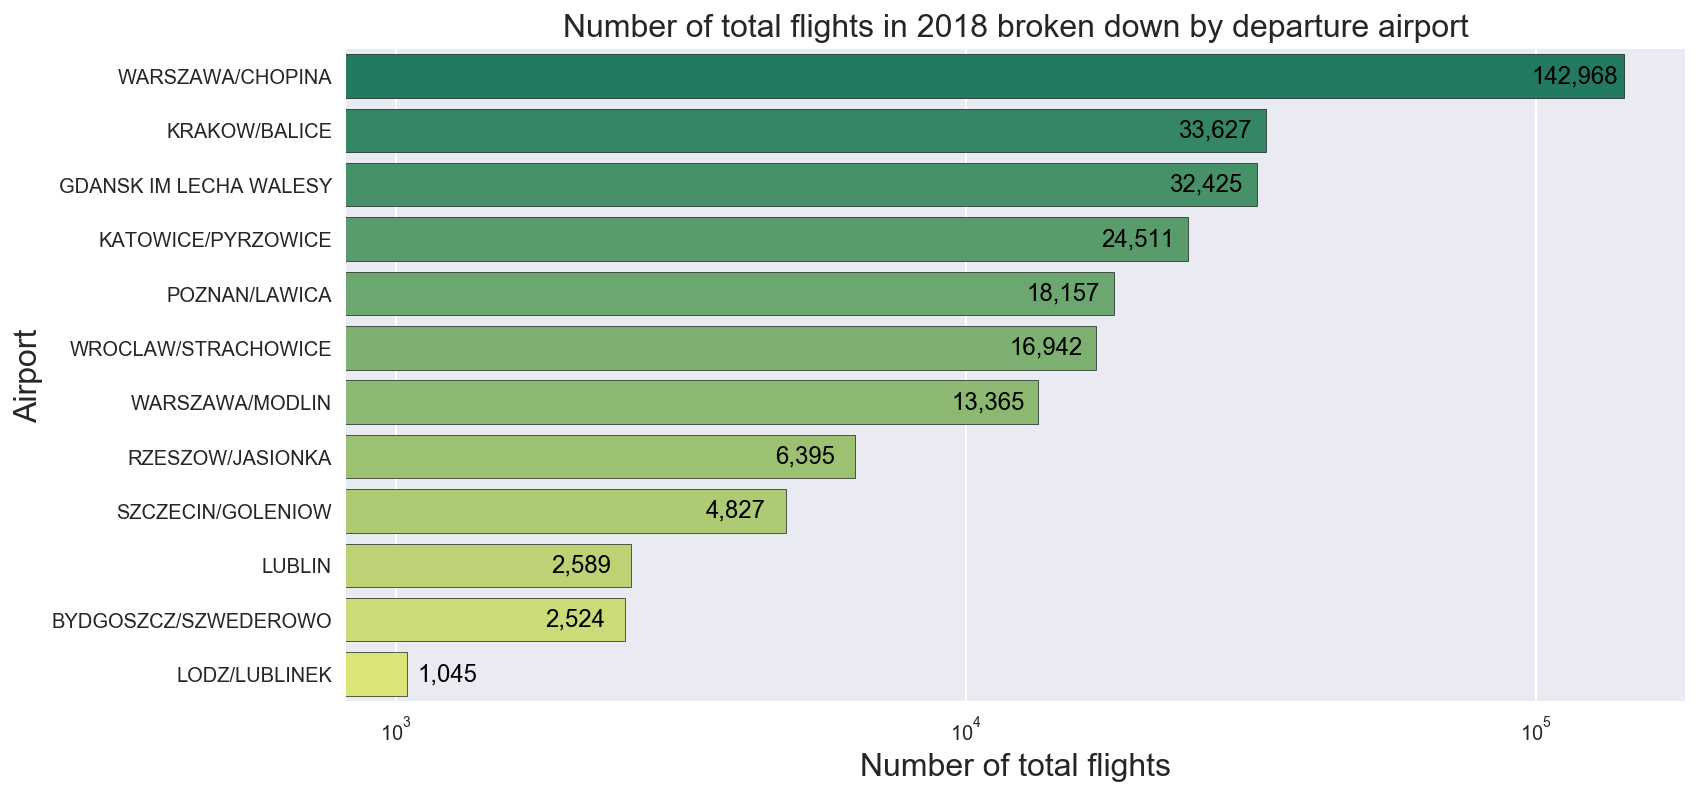

In [27]:
bar_chart = departure.sort_values('Flights', ascending=False)
plt.style.use('seaborn')
plt.figure(figsize=(12,6))
plot = sns.barplot(
    x=bar_chart['Flights'], 
    y=bar_chart.index, 
    orient='h', 
    log=True, 
    edgecolor='black',
    order=bar_chart.index,
    palette='summer')
#The chart uses a logarithmic scale with respect to the Y axis, because the data on 
#the airport with the largest number of departures differ radically from
#the one with the smallest number - this will allow for better arrangement of data on the chart.
for p in plot.patches[:-1]:
    plot.annotate(s='{:,}'.format(int(p.get_width())),xy=(p.get_width(), p.get_y() + p.get_height()/2),
    ha='center', va='center', xytext=(-25, 0), textcoords='offset points', color='black',
    fontsize=12)
plot.annotate(
    s='{:,}'.format(int(plot.patches[-1].get_width())),
    xy=(plot.patches[-1].get_width(), plot.patches[-1].get_y() + plot.patches[-1].get_height()/2),
    ha='center', va='center', xytext=(20, 0), textcoords='offset points', color='black', fontsize=12)
plt.title('Number of total flights in 2018 broken down by departure airport', fontsize=16)  
plt.xlabel('Number of total flights', fontsize=16)
plt.ylabel('Airport', fontsize=16)
plt.show()

The graph shows that Warsaw Chopin Airport serves the largest number of flights. At the same time one can see that Lublin airport is not very popular and the number of flights departing from Warsaw Chopin Airport is more than 136 times bigger. What's more, the Kraków airport, with the second place, had 4 times less flights in 2018.

In the next step, the annual number of flights will be analysed depending on the departure airport.

In [28]:
#creating bins to group data into years
yearly_bins = pd.date_range('2004-01-01', periods=16, freq='YS')

departured = df.groupby(['Departure', pd.cut(df.index, yearly_bins, right=False)]).sum()['Flights']
departured = departured.unstack().transpose()
departured.index = [year for year in range(2004,2019)]
departured = departured.replace(0, np.nan)

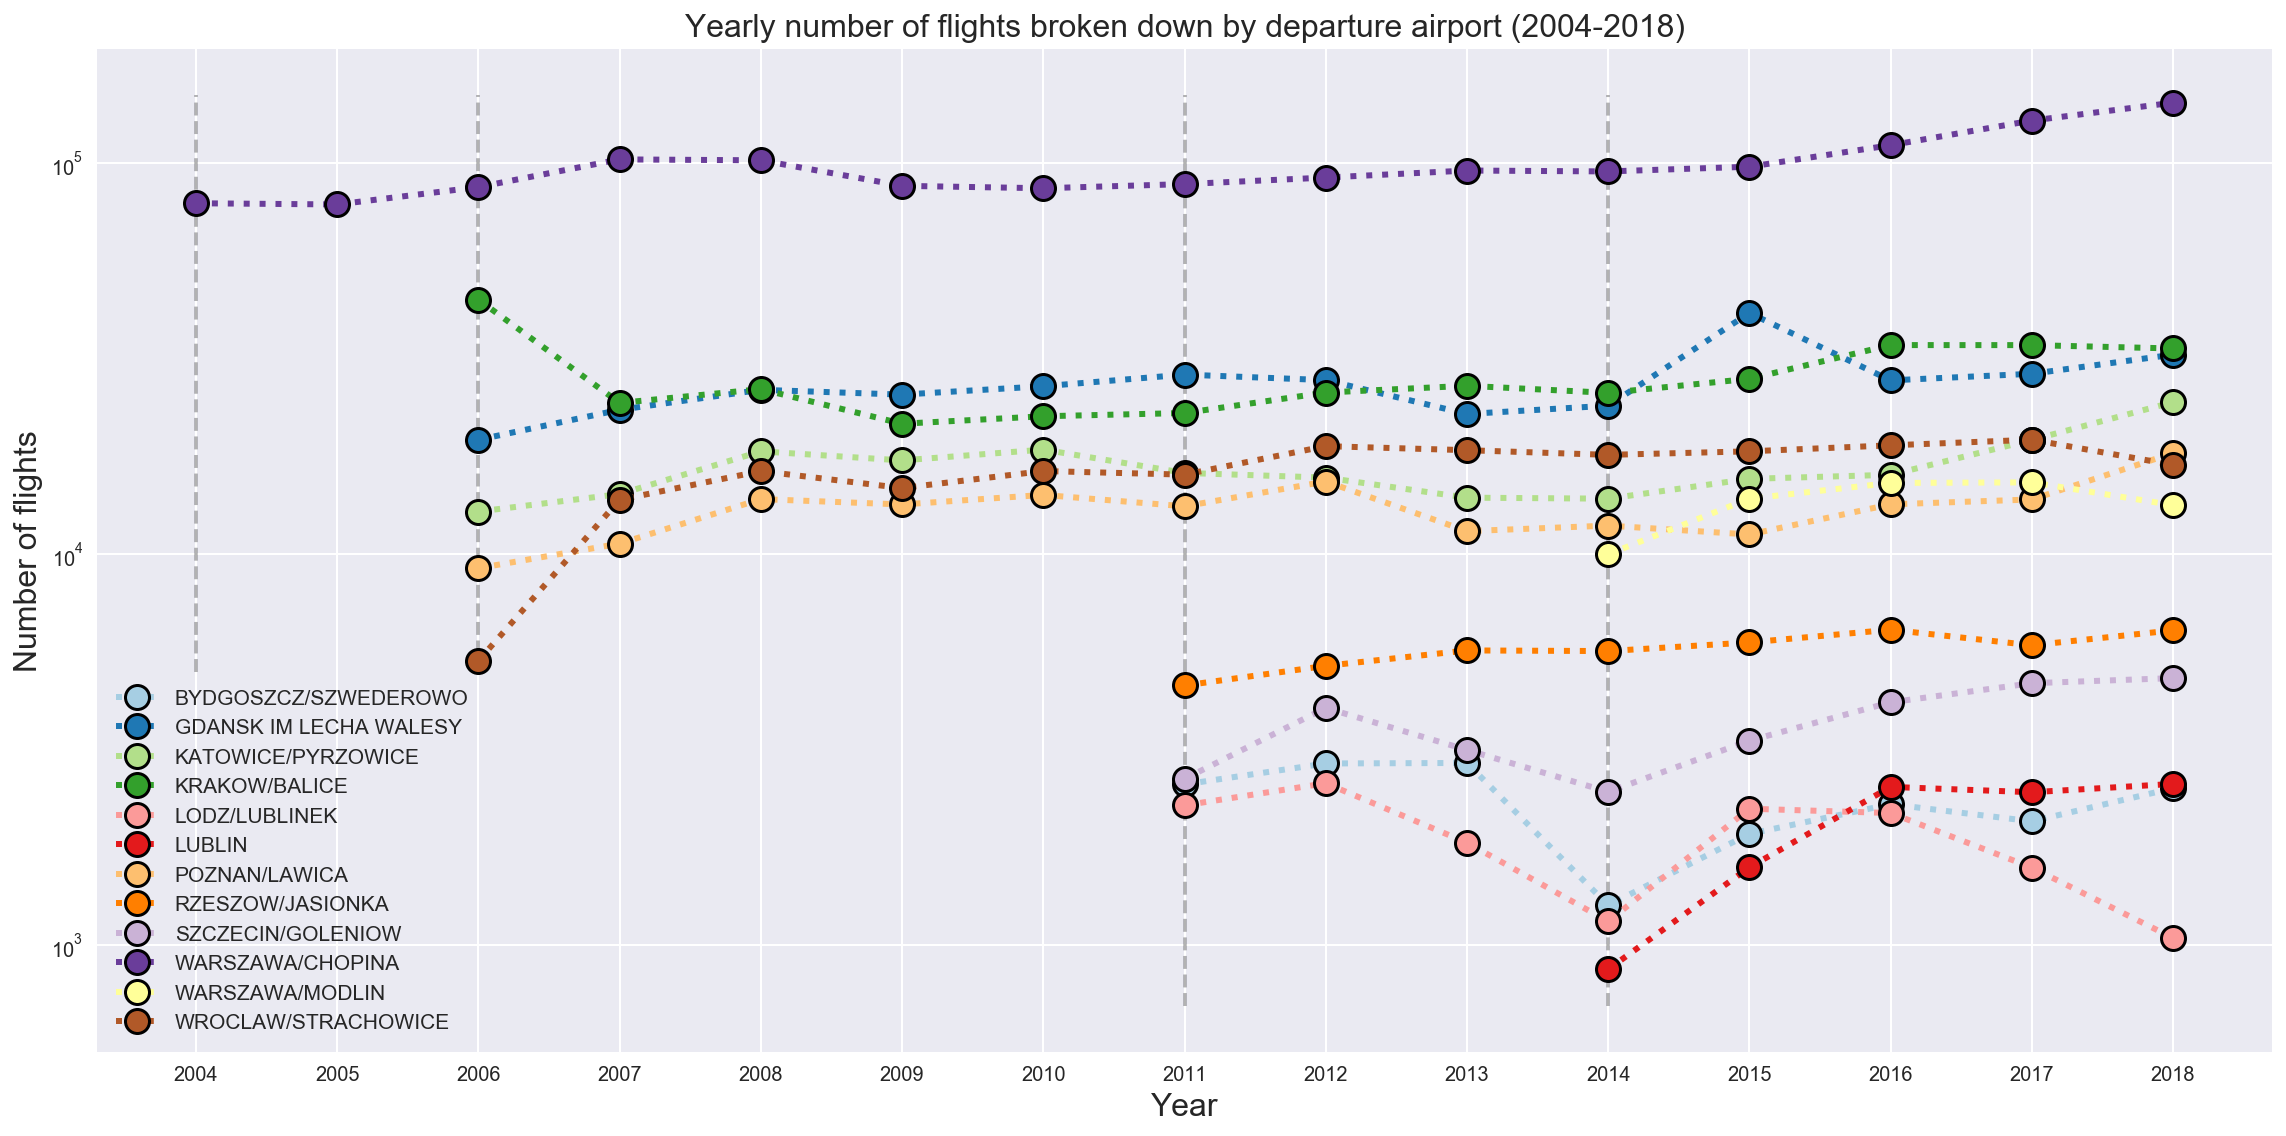

In [29]:
plt.figure(figsize=(16,8))
for column, color in zip(departured.columns, sns.color_palette('Paired', 12)):
    plt.plot(departured[column], label=column, color=color, lw=3, marker='o', ls=':', 
             markeredgecolor='black', markeredgewidth=1.5, markersize=12, alpha=1)
plt.yscale('log')
plt.xticks(departured.index)
plt.title('Yearly number of flights broken down by departure airport (2004-2018)', fontsize=16)  
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of flights', fontsize=16)
plt.legend(prop={'size':10.5})
plt.vlines([2004, 2006], 5000, 150000, linestyles='--', alpha=.3)
plt.vlines([2011, 2014], 700, 150000, linestyles='--', alpha=.3)
plt.tight_layout()
plt.show()

The graph above shows the annual number of flights. First of all, it should be emphasized that due to the large variation in data levels, a logarithmic scale was adopted on the Y axis. Vertical dashed lines mark the years in which data on new airports appears - these are the years 2004, 2006, 2011 and 2014.

It can be seen that airports can be divided into 3 groups. The first of them is solely Warsaw Chopin Airport, which has the highest number of flights throughout the whole analysed period. The second group with an average level contains, among others airports in Krakow or Wroclaw. The last group is the smallest airports, i.e. Lublin and Szczecin.

In general, it should be noted that airports have been more or less stable in the number of flights per year in recent years. The exception is Lublin airport, where the number of flights has dropped significantly since 2015.

Another thing is analysis of domestic and international flights.

In [30]:
#creating new column with form of flight
df['Form_of_flight'] = df['Arrival'].apply(
    lambda airport: 'Domestic' if airport in df['Departure'].unique() else 'International')
df['Form_of_flight'] = df['Form_of_flight'].astype('category')

df.head()

,Departure,Arrival,Flights,Passengers,Seats,Form_of_flight
2004-01-01,BYDGOSZCZ/SZWEDEROWO,BURGAS,NaN,NaN,NaN,International
2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,NaN,NaN,NaN,International
2004-01-01,BYDGOSZCZ/SZWEDEROWO,NIEDERRHEIN,NaN,NaN,NaN,International
2004-01-01,BYDGOSZCZ/SZWEDEROWO,GIRONA,NaN,NaN,NaN,International
2004-01-01,BYDGOSZCZ/SZWEDEROWO,DUBLIN,NaN,NaN,NaN,International


The proportion of flight types in 2012 will be analysed.

In [31]:
#creating date range of 12 months in 2012
one_year = pd.date_range('2012-01-01', periods=12, freq='MS')

flight_type = df.dropna().loc[one_year]['Form_of_flight'].value_counts()
flight_type

International    2046
Domestic          240
Name: Form_of_flight, dtype: int64

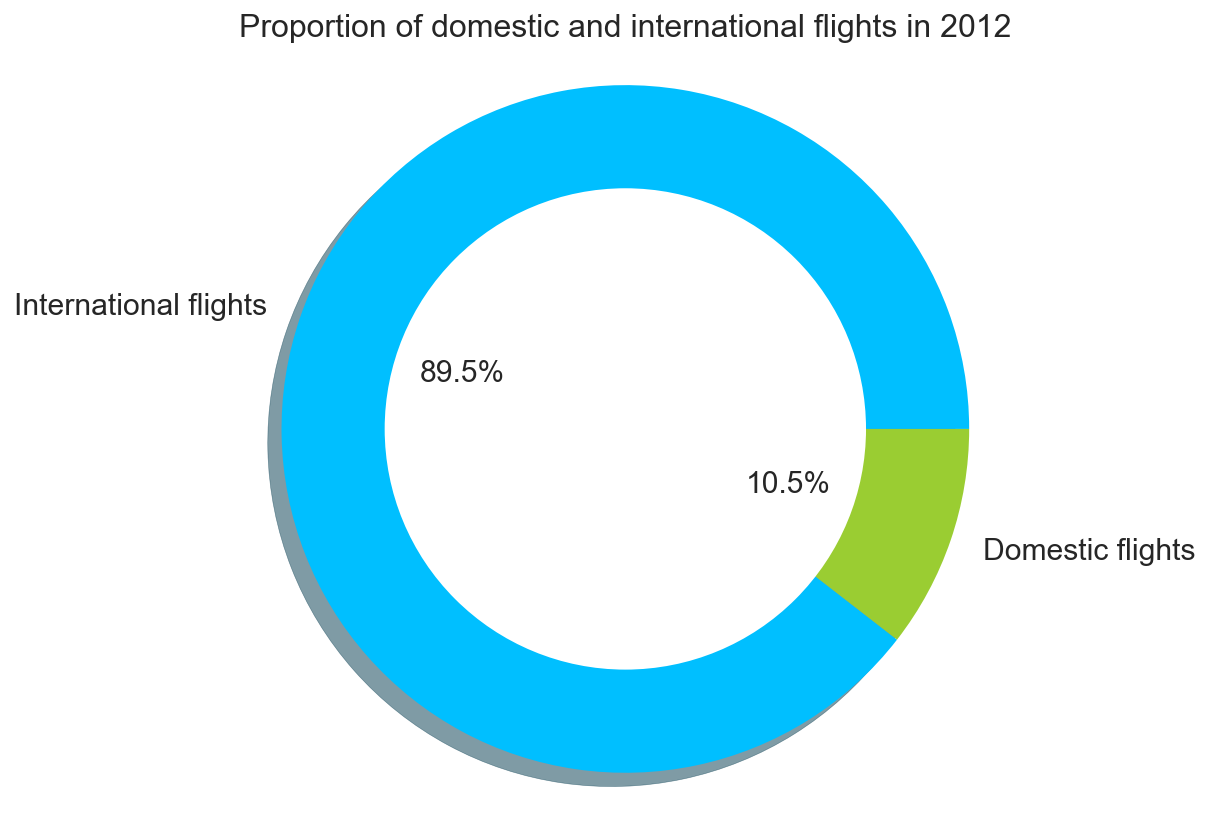

In [32]:
plt.figure(figsize=(9,7))
plt.pie(
    flight_type, 
    labels=['International flights', 'Domestic flights'],
    colors=['deepskyblue', 'yellowgreen'],
    autopct='%.1f%%',
    pctdistance=.5,
    textprops={'fontsize': 15},
    shadow=True)

centre_circle = plt.Circle((0,0), .7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title('Proportion of domestic and international flights in 2012', 
          fontdict={'fontsize':16})
plt.show()

As can be seen, foreign flights are definitely more frequent than domestic flights. However, the data show information for a given year, which says nothing about how this proportion changes over time - this will be analysed next.

In [33]:
flight_type_all = df.dropna()['Form_of_flight']
flight_type_all = flight_type_all.groupby(
    pd.cut(flight_type_all.index, yearly_bins, right=False)).value_counts().to_frame()
flight_type_all['Percentage'] = flight_type_all.groupby(level=0).transform(lambda x: (x / x.sum()).round(3))
flight_type_all.rename({'Form_of_flight' : 'Number_of_flights'}, axis=1, inplace=True)
flight_type_all.head()

Number_of_flights  Percentage
                         Form_of_flight                               
[2004-01-01, 2005-01-01) International                 276       0.821
                         Domestic                       60       0.179
[2005-01-01, 2006-01-01) International                 288       0.828
                         Domestic                       60       0.172
[2006-01-01, 2007-01-01) International                1165       0.902

By using the pd.cut() function and data grouping, a table showing the evolution of share of domestic and foreign flights over time can be created.

Additional display on the chart may facilitate reading the trend.

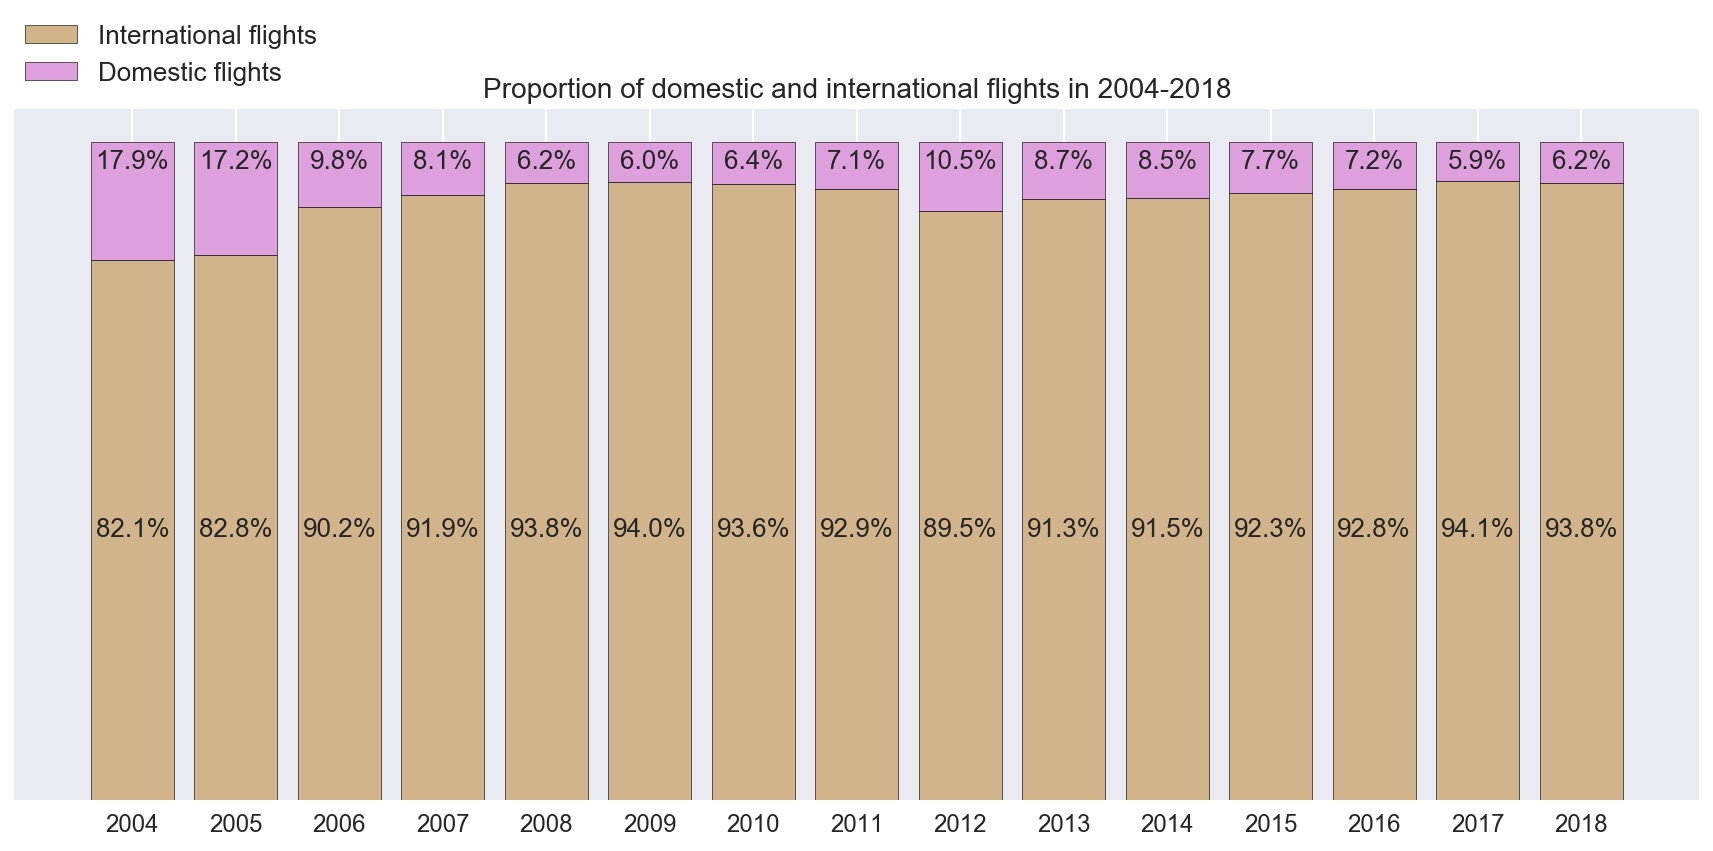

In [34]:
#creating additional filters
inter = flight_type_all.index.get_level_values(1) == 'International'
domes = flight_type_all.index.get_level_values(1) == 'Domestic'
labels_dates = [year for year in range(2004,2019)]

plt.figure(figsize=(12,6))
#creating bar charts separately and placing them on each other
bar1 = plt.bar(
    labels_dates, 
    flight_type_all[inter]['Percentage'], 
    label='International flights',
    edgecolor='black',
    color='tan')
bar2 = plt.bar(
    labels_dates, 
    flight_type_all[domes]['Percentage'],    
    bottom=flight_type_all[inter]['Percentage'],    
    label='Domestic flights', 
    edgecolor='black',
    color='plum')

plt.xticks(labels_dates)
plt.tick_params('both', labelsize=12)
plt.title('Proportion of domestic and international flights in 2004-2018', fontdict={'fontsize':14})
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', 
           mode="expand", borderaxespad=0., prop={'size':13})
plt.yticks([])
#inputting data on the chart
for r1, r2 in zip(bar1, bar2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x()+r1.get_width()/2, 0.4, '{:.1%}'.format(h1), ha="center", fontsize=13)
    plt.text(r2.get_x()+r2.get_width()/2, 0.96 ,'{:.1%}'.format(h2), ha="center", fontsize=13)
plt.tight_layout()
plt.show()

### number of passengers and seats
Another thing to analyse is the number of passengers and availed seats.

In [35]:
df['Passengers'].describe()

count    33950.000000
mean      8797.671988
std       7680.322685
min          0.000000
25%       3504.000000
50%       6315.000000
75%      11065.000000
max      65613.000000
Name: Passengers, dtype: float64

In this case, the passenger distribution is also quite spread. And although it is also right-skewed, it is not as much as the number of flights. Number 65k passengers on a given connection may be too high for only one month, but this is not as obvious as the maximum number of flights.

The number of passengers will be checked over the years. Unlike previous analyses, which were carried out at general level or broken down by airport, in this case only one airport will be selected, from which the number of passengers will be calculated each year.

In [36]:
df[df['Departure']=='KRAKOW/BALICE']['Passengers'].resample('A').sum()

2004-12-31          0.0
2005-12-31          0.0
2006-12-31    2166217.0
2007-12-31    2188780.0
2008-12-31    2369201.0
2009-12-31    2038303.0
2010-12-31    2157216.0
2011-12-31    2391760.0
2012-12-31    2635381.0
2013-12-31    2780391.0
2014-12-31    3006601.0
2015-12-31    3473622.0
2016-12-31    4206165.0
2017-12-31    4343552.0
2018-12-31    4388947.0
2019-12-31    3833077.0
Freq: A-DEC, Name: Passengers, dtype: float64

In [37]:
balice = df[df['Departure']=='KRAKOW/BALICE']['Passengers']
balice_yearly = balice.groupby(pd.cut(balice.index, yearly_bins, right=False)).sum()
balice_yearly.index = [year for year in range(2004,2019)]
balice_yearly

2004          0.0
2005          0.0
2006    2166217.0
2007    2188780.0
2008    2369201.0
2009    2038303.0
2010    2157216.0
2011    2391760.0
2012    2635381.0
2013    2780391.0
2014    3006601.0
2015    3473622.0
2016    4206165.0
2017    4343552.0
2018    4388947.0
Name: Passengers, dtype: float64

For some reason, you can see that there is a lack of data in the downloaded dataset - for this reason, the chart should be narrowed so the period excludes the first two years.

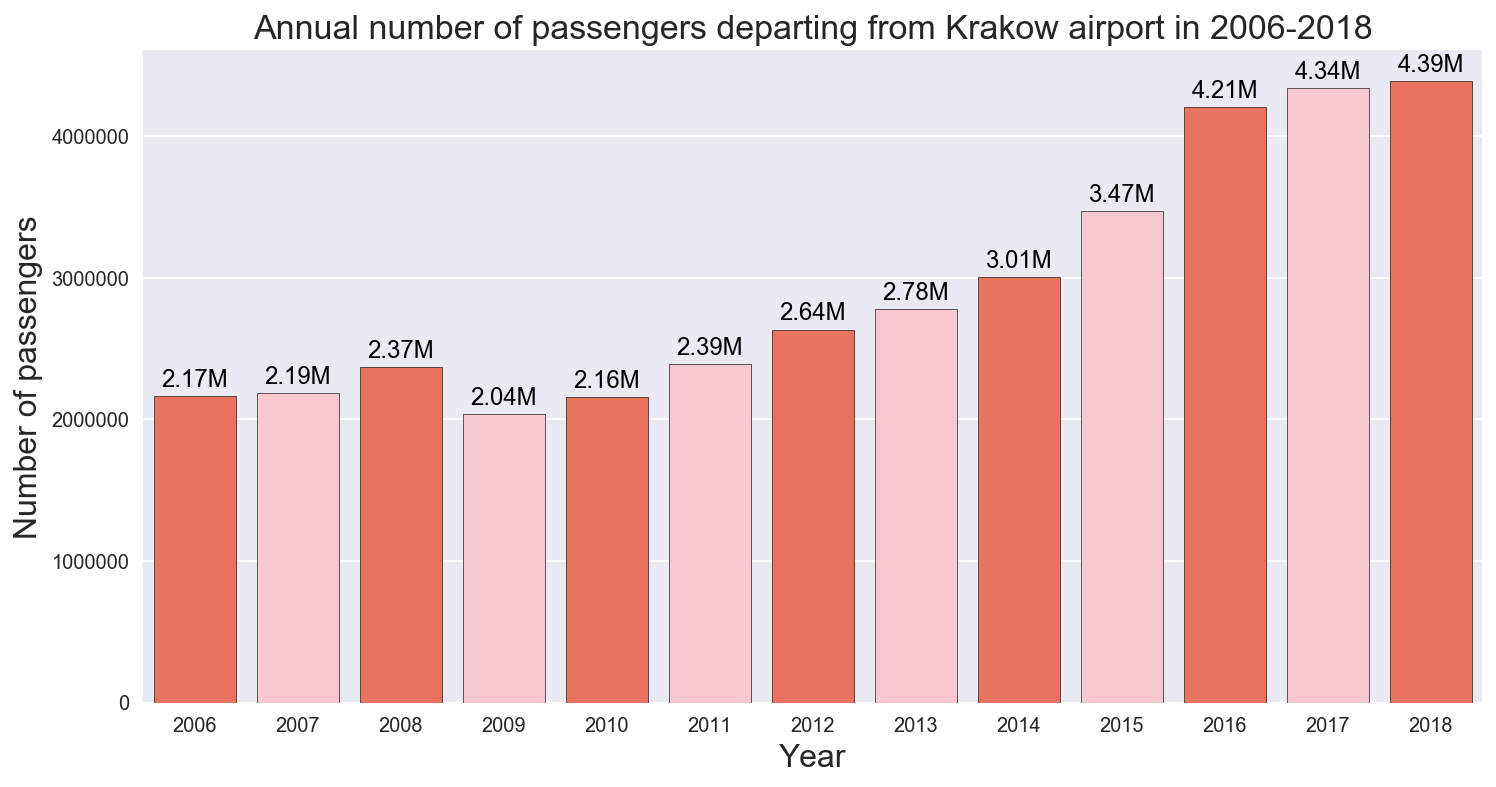

In [38]:
plt.figure(figsize=(12,6))
plot = sns.barplot(
    balice_yearly.index[2:], 
    balice_yearly[2:], 
    edgecolor='black', 
    palette=['tomato', 'pink'])
for p in plot.patches:
    plot.annotate(
        s='{}M'.format(round(p.get_height()/1000000,2)), 
        xy=(p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 8), 
        textcoords='offset points',
        color='black',
        fontsize=12)
plt.title('Annual number of passengers departing from Krakow airport in 2006-2018', fontdict={'fontsize':17})
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of passengers', fontsize=16)
plt.show()

The diagram shows that the number of passengers increased during the analysed period - with a slight decrease in 2009 - the decrease may be associated with  the financial crisis.

Another thing you can examine on the data is the popularity of a given direction among passengers.

In [39]:
#creating pivot table to sum the number of passengers
dest_pop = df.pivot_table(index='Arrival', aggfunc='sum')['Passengers'].to_frame()

#creating additional columns containing information on the 
#share of passengers using a given airport in the total number of passengers
#departing from Poland and creating their ranking
dest_pop['Percentage'] = (dest_pop['Passengers'] / dest_pop['Passengers'].sum()).apply('{:.3%}'.format)
dest_pop['Ranking'] = dest_pop['Passengers'].rank(ascending=False, method='max')
dest_pop = dest_pop.sort_values('Ranking')
dest_pop['Passengers'] = dest_pop['Passengers'].astype('int')

In [40]:
dest_pop.head(10)

,Passengers,Percentage,Ranking
Arrival,,,
LONDON STANSTED,18356445,6.146%,1.0
LONDON LUTON,16758786,5.611%,2.0
WARSZAWA/CHOPINA,16223980,5.432%,3.0
FRANKFURT/MAIN,15385128,5.151%,4.0
MUENCHEN,11951460,4.001%,5.0
DUBLIN,9789459,3.278%,6.0
PARIS-CHARLES DE GAULLE,8474368,2.837%,7.0
LONDON HEATHROW,6638804,2.223%,8.0
AMSTERDAM/SCHIPHOL,6564663,2.198%,9.0


As can be seen in the table above - the top 10 most popular destination among passengers. It is not surprising that the first two places are airports in located in London, UK - which is the main centre of Polish emigration in recent years. What is surprising is the very high position of the Warsaw airport. Despite the fact that domestic flights constitute a very small share of all flights, Chopin airport was ranked as third. This airport must be the main destination for domestic travel.

Having the number of passengers on a given line and information about the available number of seats, it is possible to calculate the occupancy rate - this will indicate the popularity of the given connection.

In [41]:
df['Ratio'] = df['Passengers'] / df['Seats']
(df['Ratio'] > 1).sum()

315

In [42]:
print('{:.2%}'.format((df['Ratio'] > 1).sum() / df.dropna().shape[0]))

0.93%


First of all, it should be noted that some information seems to contain errors - the total number of available seats is lower than the number of passengers in a given connection. This is definitely a mistake, as it is impossible for standing spaces to be sold. Fortunately, the number of rows is only slightly over 300, which is not even 1% of all records - in further analysis these rows will be omitted.

In [43]:
#calculating passenger-seat ratio for each connection
seat_ratio = df[df['Ratio'] <= 1].groupby(['Departure', 'Arrival']).mean().dropna()['Ratio']
seat_ratio

Departure             Arrival                    
BYDGOSZCZ/SZWEDEROWO  ANTALYA                        0.928746
                      BIRMINGHAM                     0.938595
                      BURGAS                         0.883980
                      DUBLIN                         0.911342
                      FRANKFURT/MAIN                 0.628684
                                                       ...   
WROCLAW/STRACHOWICE   TEL-AVIV/BEN GURION            0.785328
                      TENERIFE SUR/REINA SOFIA       0.936781
                      WARSZAWA/CHOPINA               0.687634
                      WARSZAWA/MODLIN                0.716245
                      ZAKINTHOS/DIONISIOS SOLOMOS    0.961638
Name: Ratio, Length: 516, dtype: float64

The main results are presented below.

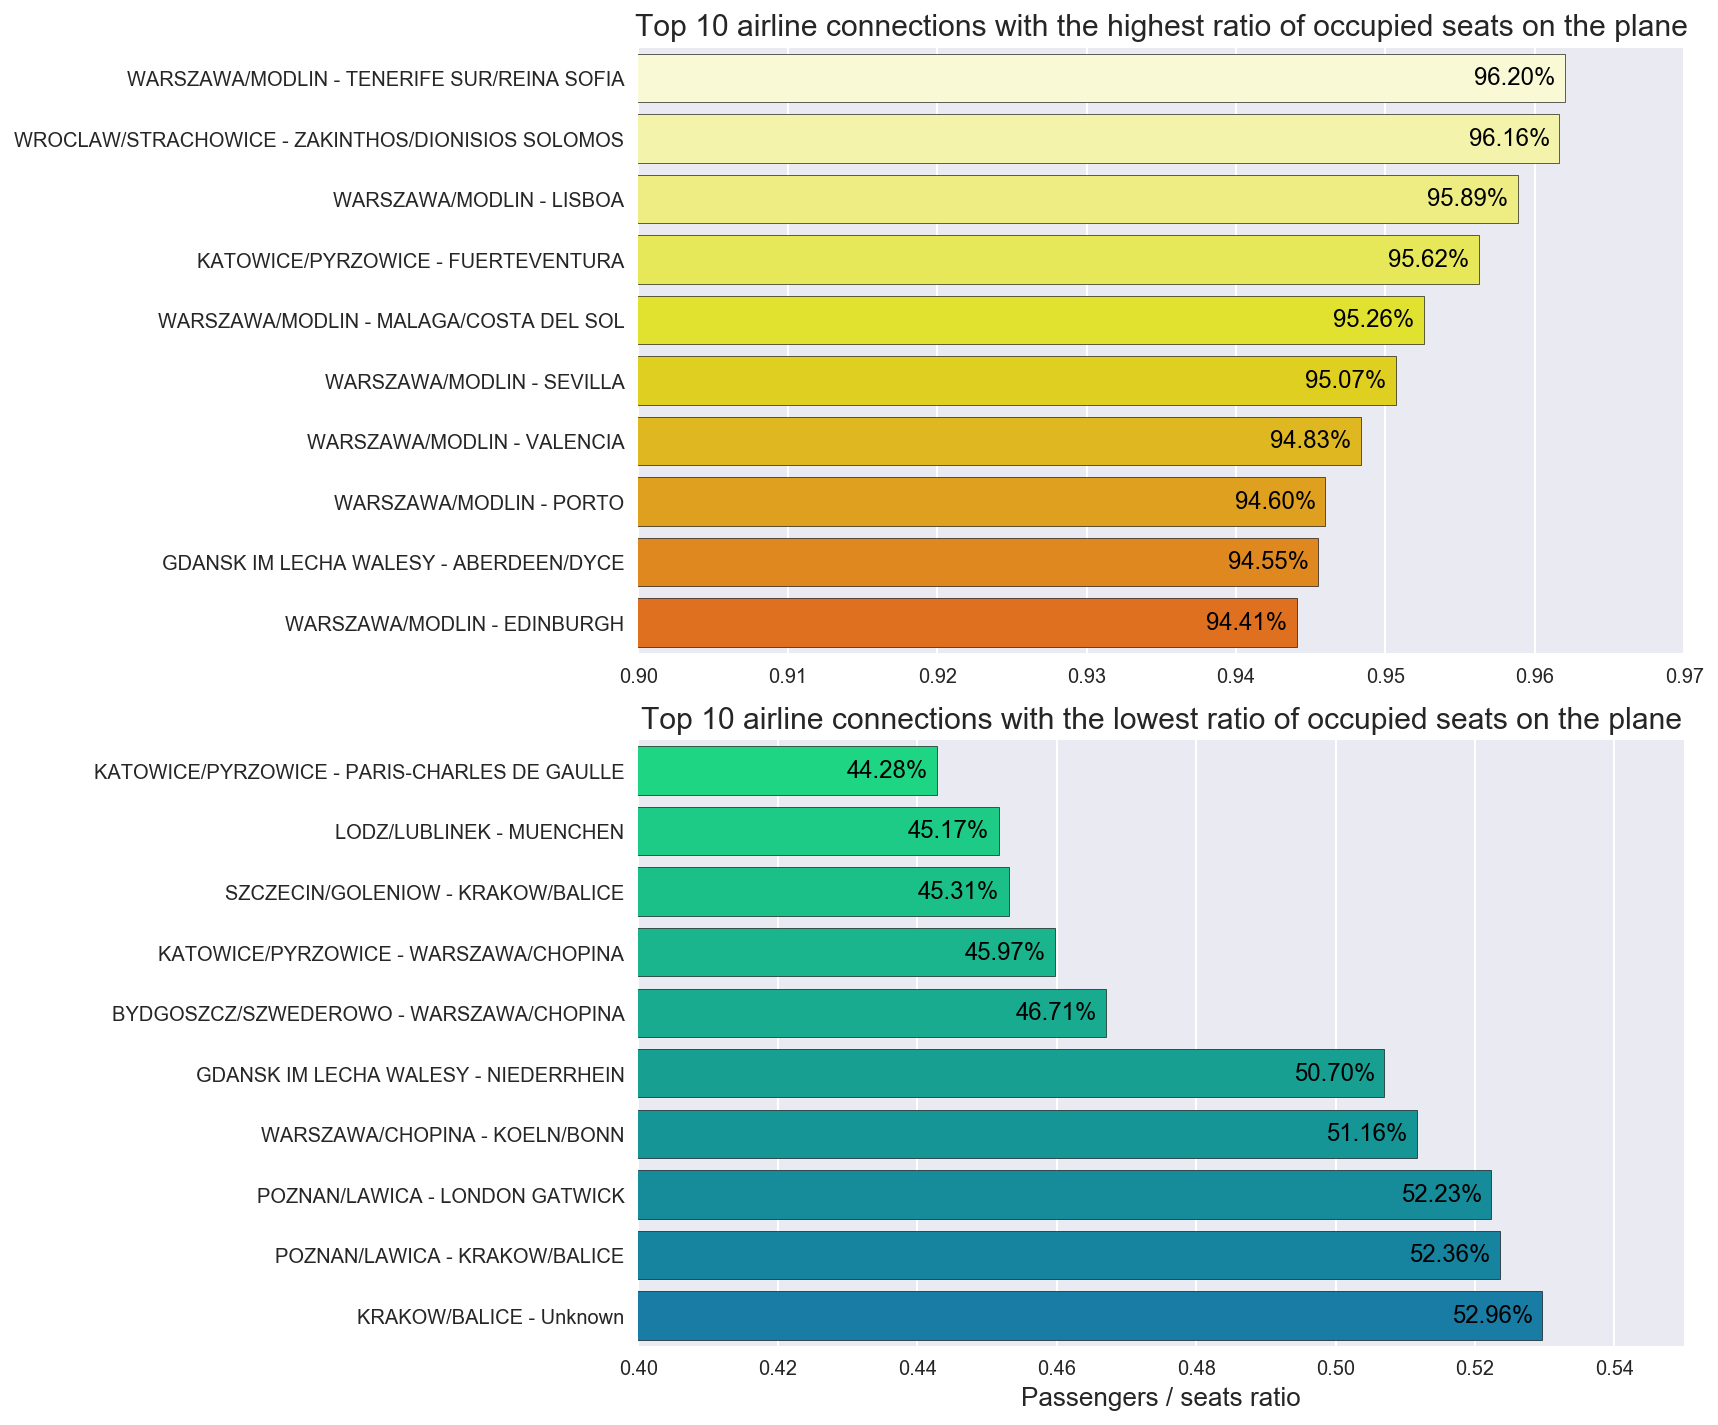

In [44]:
#creating labels for Y axis
yticks1 = []
yticks2 = []
for i in range(10):
    yticks1.append(' - '.join(seat_ratio.sort_values(ascending=False).index[i]))
    yticks2.append(' - '.join(seat_ratio.sort_values().index[i]))

plt.figure(figsize=(12,10))
plt.subplot(211)
plot=sns.barplot(
    y=seat_ratio.sort_values(ascending=False).index[:10], 
    x=seat_ratio.sort_values(ascending=False)[:10],
    orient='h',
    edgecolor='black', 
    palette=sns.color_palette('hot_r', 20))
for p in plot.patches:
    plot.annotate(s='{:.2%}'.format(p.get_width()),xy=(p.get_width(), p.get_y() + p.get_height()/2),
    ha='center', va='center', xytext=(-25, 0), textcoords='offset points', color='black',
    fontsize=12)
plt.yticks(np.arange(10), yticks1)
plt.title('Top 10 airline connections with the highest ratio of occupied seats on the plane', 
          fontdict={'fontsize':15})
plt.xlabel('')
plt.xlim(0.9, 0.97)

plt.subplot(212)
plot=sns.barplot(
    y=seat_ratio.sort_values().index[:10], 
    x=seat_ratio.sort_values()[:10],
    orient='h',
    edgecolor='black', 
    palette=sns.color_palette('winter_r', 20))
for p in plot.patches:
    plot.annotate(s='{:.2%}'.format(p.get_width()),xy=(p.get_width(), p.get_y() + p.get_height()/2),
    ha='center', va='center', xytext=(-25, 0), textcoords='offset points', color='black',
    fontsize=12)
plt.yticks(np.arange(10), yticks2)
plt.xlim(0.4, 0.55)
plt.title('Top 10 airline connections with the lowest ratio of occupied seats on the plane', 
          fontdict={'fontsize':15})
plt.xlabel('Passengers / seats ratio', fontdict={'fontsize':13})
plt.tight_layout()
plt.show()

It should be noted that the flights with the highest ratio value are mainly holiday destinations. These are connections between large urban centres (such as Warsaw, Wrocław) and tourist places located mainly near the Mediterranean Sea and the Canary Islands. This is probably due to the significant increase in foreign holiday destinations in recent years and also the fact that such trips are organized by travel agencies. In the case of any extra vacancies, tours are sold as "last minute" for a lower fee to fill flights and hotels as much as possible, even with less profit.

On the other hand,  connections with the lowest ratio of occupancy are not as easy to describe. To a large extent, these are domestic connections between smaller cities. The rest are international, but also with departure from smaller cities, such as Katowice and Łódź.

# Data forcasting with ARIMA model

It may be interesting to prepare prediction for the number of passengers on a single connection in the analyzed period of time. The those numbers may be crucial for airports to estimate future demand.  

First, a graph of the number of passengers on the Warsaw - Frankfurt route will be prepared. Next, the prediction of future passenger numbers will be created, based solely on historical data. It should be noted, however, that the exact number also depends on external factors, including such as financial situations or the number of seats available on planes.


In [45]:
#creating additional filters to find data for only one route
warsaw = df['Departure'] == 'WARSZAWA/CHOPINA'
dublin = df['Arrival'] == "MUENCHEN"
#grouping and summing data
war_mue = df[warsaw & dublin].groupby(level=0).sum()
#setting time frequency to month
war_mue.index.freq = 'MS'

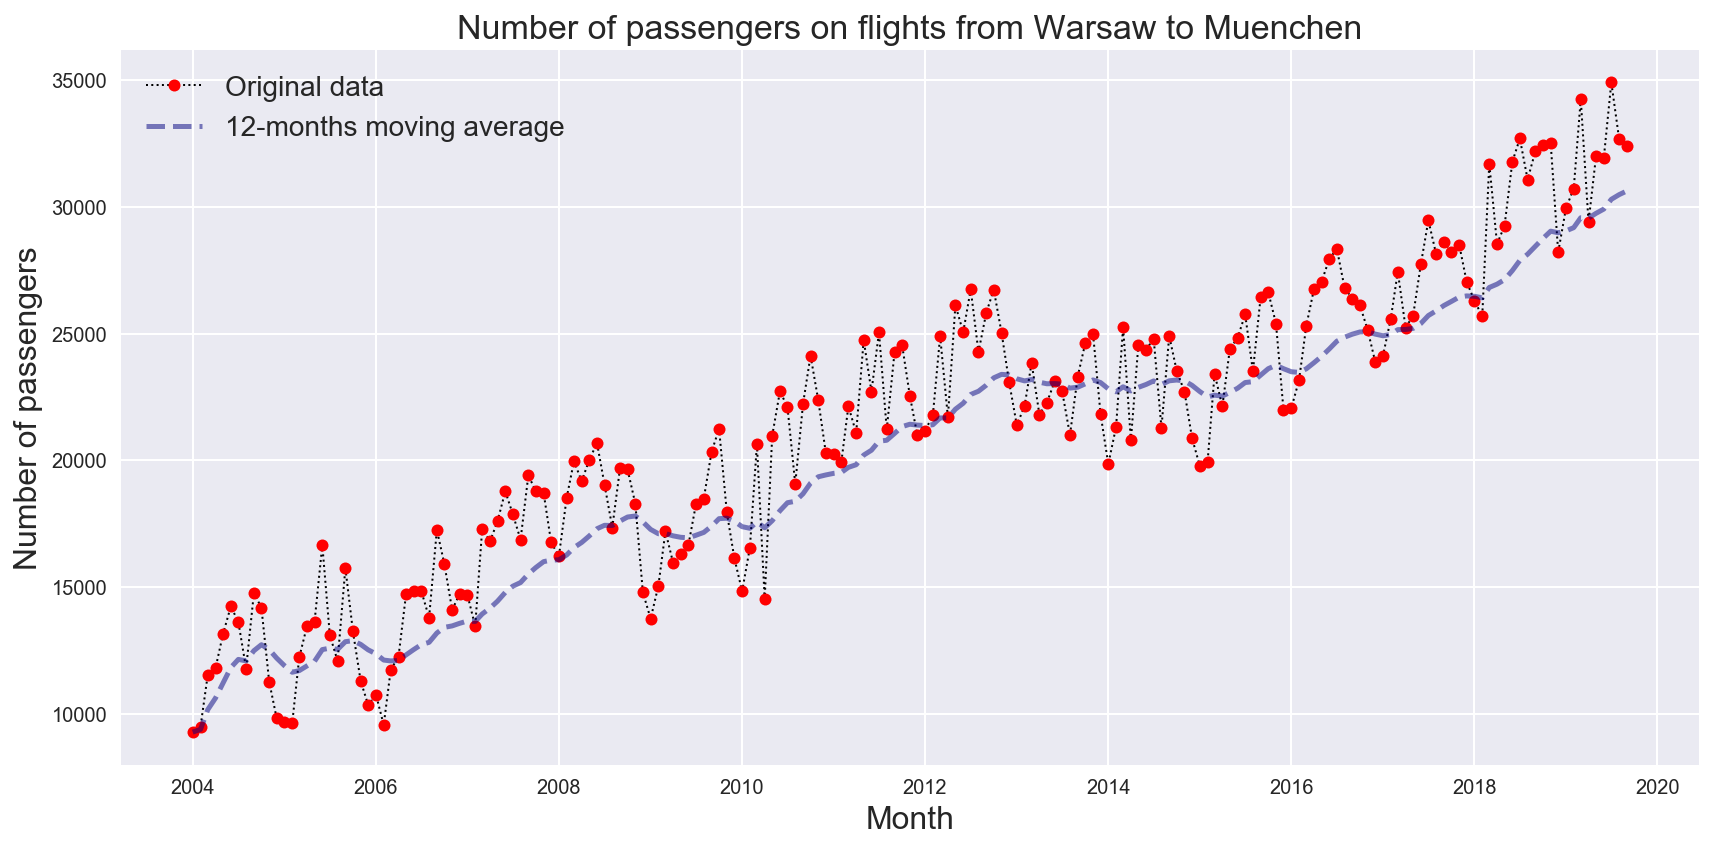

In [46]:
plt.figure(figsize=(12,6))
plt.plot(war_mue['Passengers'], ls=':', marker='o', markersize=6, lw=1, 
         color='black', markerfacecolor='red', label='Original data')
plt.plot(war_mue['Passengers'].ewm(12).mean(), ls='--', lw=2.5, color='navy', 
         alpha=.5, label='12-months moving average')
plt.title('Number of passengers on flights from Warsaw to Muenchen', fontdict={'fontsize':17})
plt.xlabel('Month', fontsize=16)
plt.ylabel('Number of passengers', fontsize=16)
plt.legend(prop={'size':14})
plt.tight_layout()
plt.show()

As can be seen on the graph, the number of passengers differs over time. In general, the trend seems to be upward. The number of passengers is definitely higher in the summer months and then in the winter months - there seems to be strong seasonality in the period of 12 months. To confirm seasonality, the time series will be decomposed into trend, seasonality and residual value.

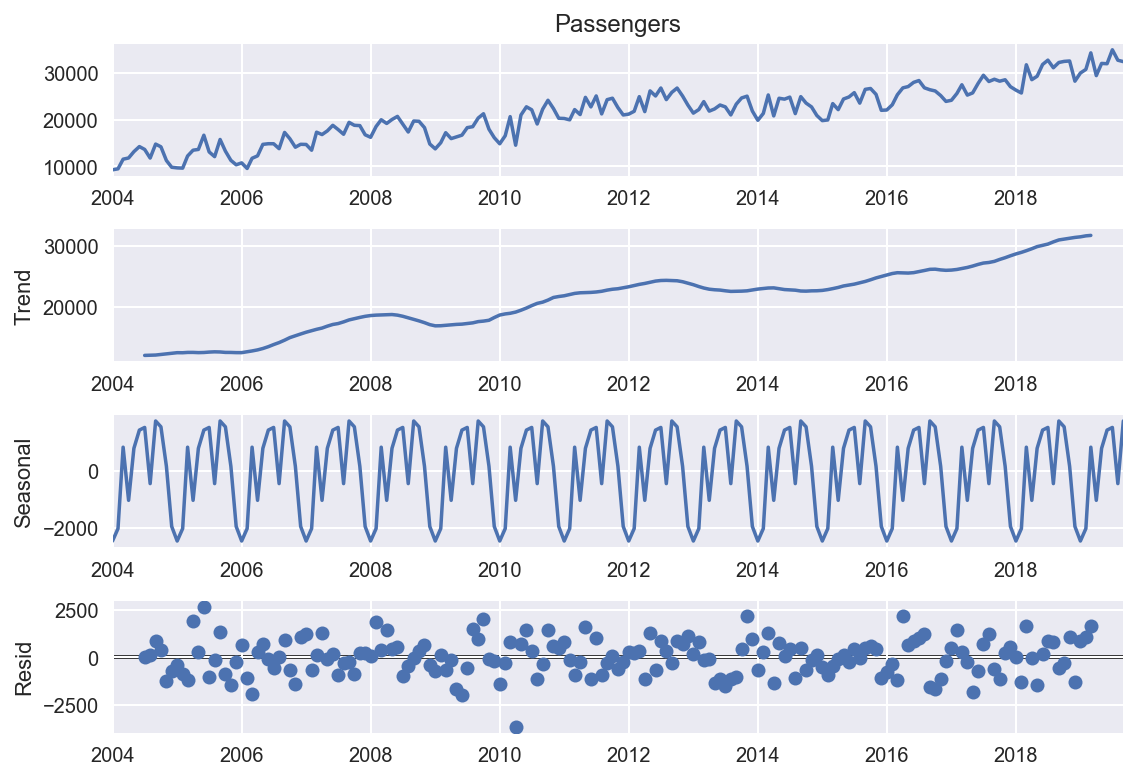

In [47]:
result = seasonal_decompose(war_mue['Passengers'], model='additive')
result.plot();

An additive rather than a multiplicative model was used, as the number of passengers appears to increase rather linearly. It has also been confirmed that the data are seasonal with a clear upward trend line. However, this means that **the data is not stationary and thereby not ready to be the base of predictions** - an Augmented Dickey-Fuller test to confirm non-stationarity is being created.

Seasonal decompose indicates a clear growing trend and quite specific seasonal value.

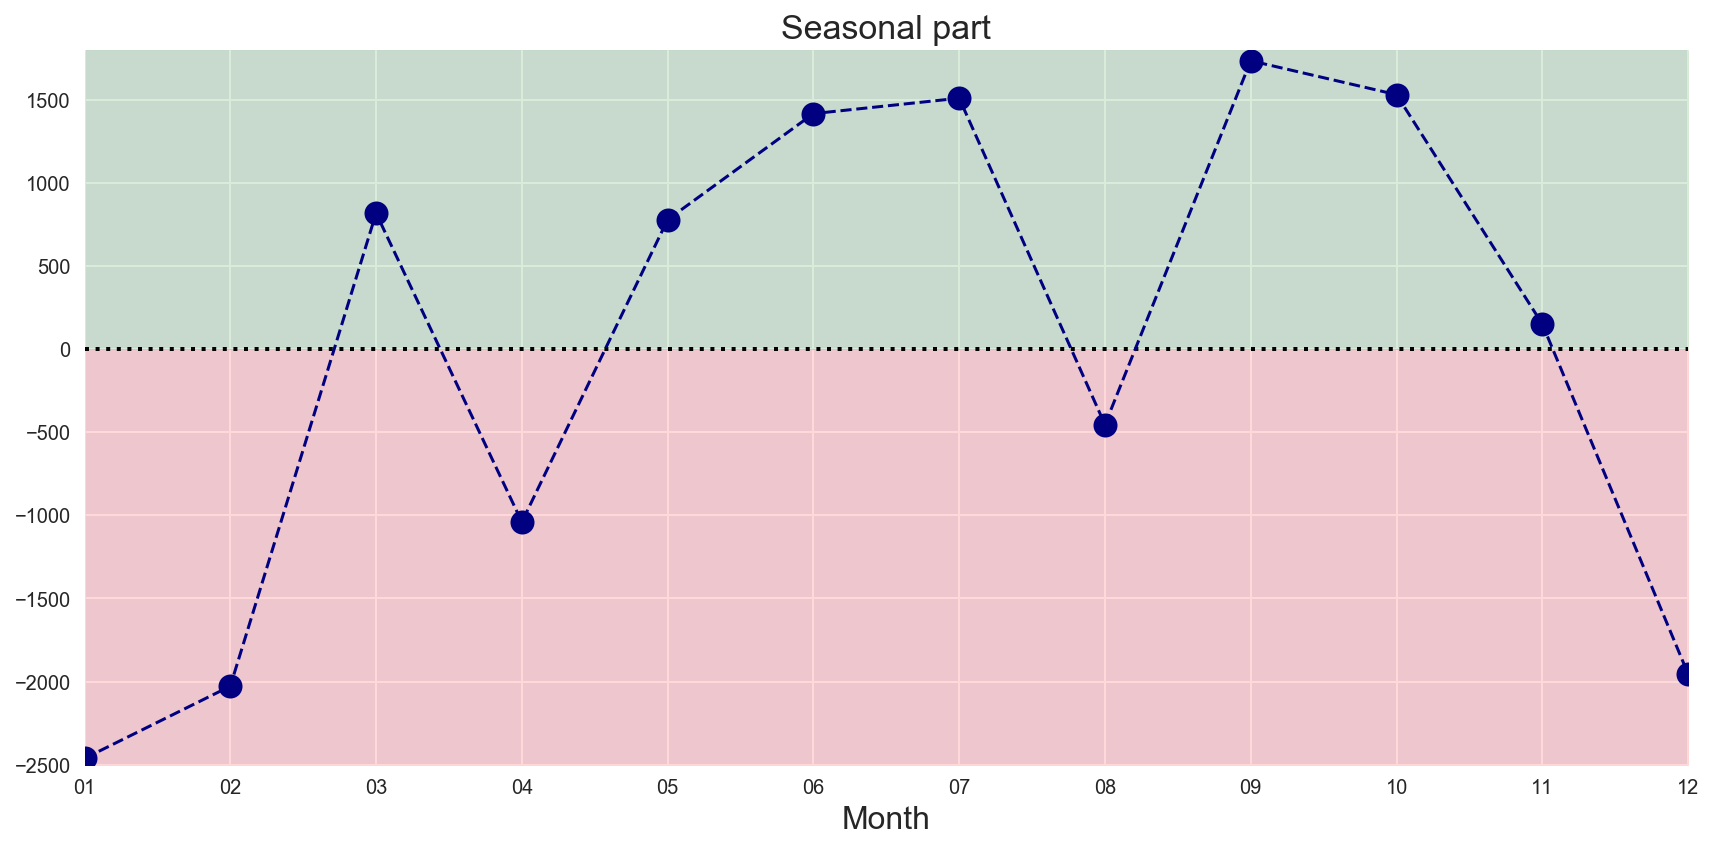

In [48]:
season = result.seasonal.loc['2004-01-01':'2004-12-01']
season.index = season.index.strftime('%m')

plt.figure(figsize=(12,6))
plt.plot(season, ls='--', lw=1.5, color='navy', marker='o', markersize=12, markerfacecolor='navy')
plt.hlines(0, '01', '12', ls=':', lw=2)
plt.fill_between(season.index, 0, 1800, color='green', alpha=.15)
plt.fill_between(season.index, -2500, 0, color='red', alpha=.15)

plt.xlim('01', '12')
plt.ylim(-2500, 1800)
plt.xticks(season.index)
plt.title('Seasonal part', fontdict={'fontsize':17})
plt.xlabel('Month', fontsize=16)

plt.tight_layout()
plt.show()

The above graph presents one-year fragment of seasonal component. It should be noted that generally in summer months the number of passengers is increased by seasonality (marked in green) and in the winter months the number decreases - however, there are exceptions when the number of passengers is reduced by the seasonality in April and August. This seasonality is repeated every year.

In [49]:
def adf(item):
    result = adfuller(item)
    labels = ['ADF Test Statistics', 'p-value', 'Number of lags', 'Number of observations']
    
    for value, label in zip(result, labels):
        print(label + ': ' + str(value))
    if result[1] <= 0.05:
        print('\nData is STATIONARY')
    else:
        print('\nData is NON-STATIONARY!')

A function has been prepared above that is designed to test a given time series with Augmented Dickey-Fuller test and determine whether a given time series is stationary (ready for analysis) or non-stationary and requiring further preprocessing.

In [50]:
adf(war_mue['Passengers'])

ADF Test Statistics: -0.6876741660794463
p-value: 0.849916426134019
Number of lags: 14
Number of observations: 174

Data is NON-STATIONARY!


The ADF test confirms that the original data is non-stationary. Because they have a seasonal character, a seasonal difference is created first, i.e. seasonal difference of 12 months. If the seasonal difference is stationary, then it will be used to forecast data.

In [51]:
war_mue['Seasonal difference'] = war_mue['Passengers'] - war_mue['Passengers'].shift(12)
war_mue.drop(['Flights', 'Seats'], axis=1, inplace=True)
adf(war_mue['Seasonal difference'].dropna())

ADF Test Statistics: -3.013212469355462
p-value: 0.033678809480131446
Number of lags: 13
Number of observations: 163

Data is STATIONARY


Seasonal difference is stationary and in theory **can be used** to predict future data. It is noteworthy that although the test indicates that the time series is stationary, p-value is quite high (0.033), and thus this value approaches dangerously to the threshold value (p-value of 0.05) above which the series is considered non-stationary.

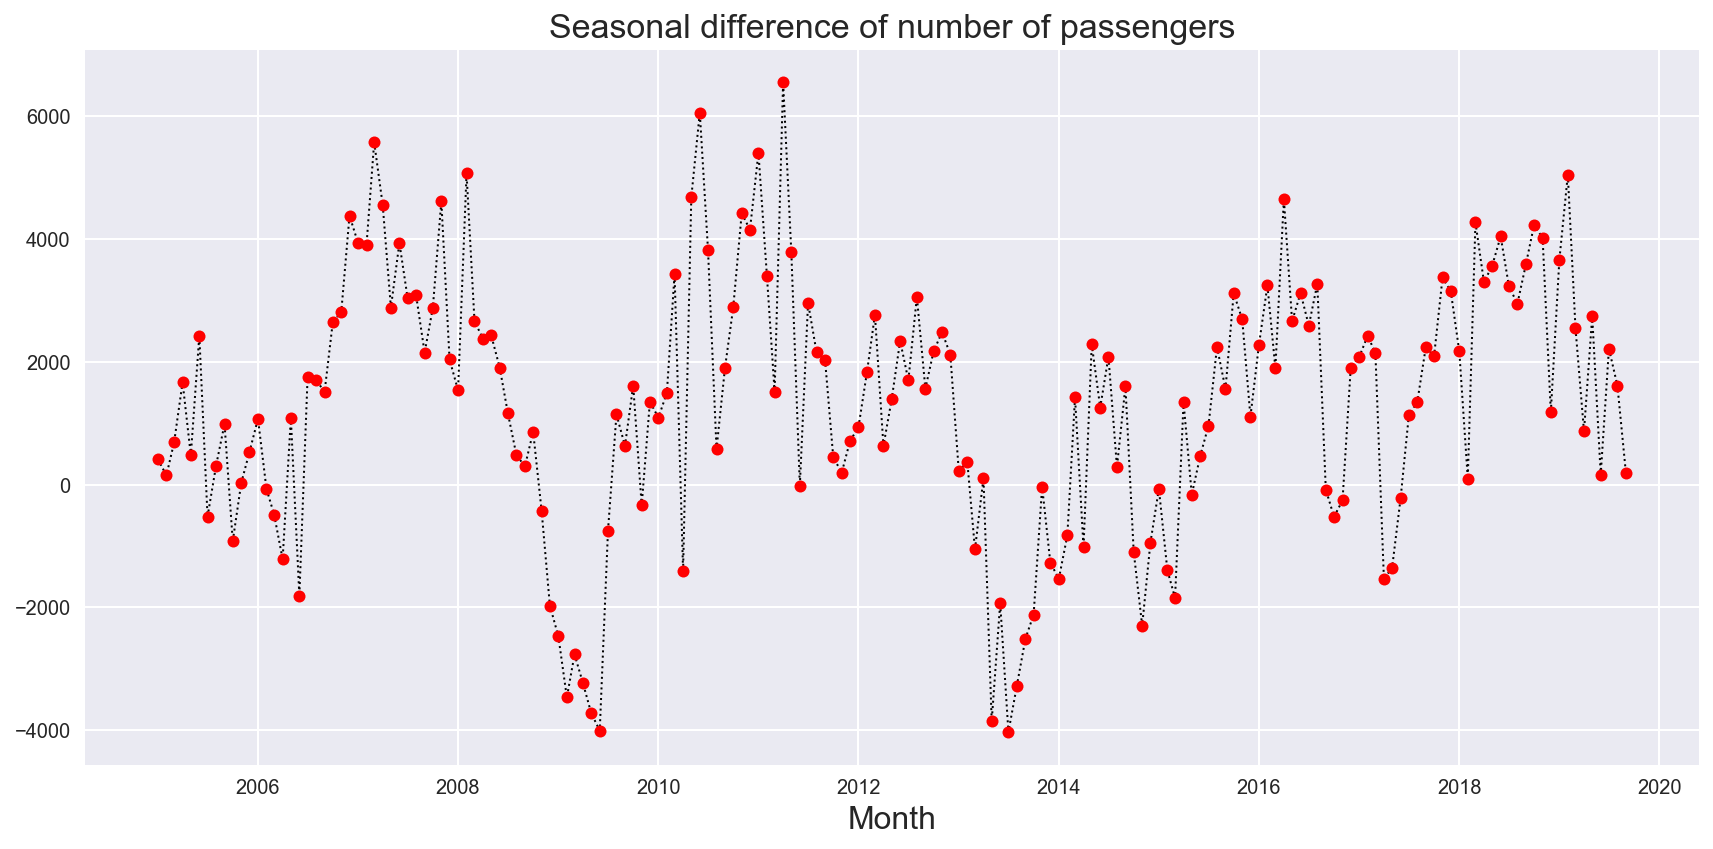

In [52]:
plt.figure(figsize=(12,6))
plt.plot(war_mue['Seasonal difference'], ls=':', marker='o', markersize=6, lw=1, 
         color='black', markerfacecolor='red')
plt.title('Seasonal difference of number of passengers', fontdict={'fontsize':17})
plt.xlabel('Month', fontsize=16)
plt.tight_layout()
plt.show()

The first differences are presented in the chart above. The time series definitely looks more stationary. There is no general trend, but it seems that in some places it seems that mean, variance, autocorrelation are not constant over time. Bearing in mind that although on the one hand the time series seems to be suitable for making a prediction, the second differentiation will also be made and the results will of both models will be compared.

First, a model based on the first differences will be created. The purpose of this analysis is not to go into advanced econometric models in detail, so in this case a function will be used that automatically calculates the appropriate parameters for the Seasonal ARIMA model, which will be used to predict future number of passengers in the time series. 

In [53]:
model_first_diffrence = auto_arima(
    y=war_mue['Passengers'], 
    start_p=0, max_p=3, 
    start_q=0, max_q=3, 
    m=12,
    start_P=0, 
    seasonal=True, 
    d=1, 
    D=1, 
    trace=False, 
    suppress_warnings=True,
    n_jobs=-1)

model_first_diffrence.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  189
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1512.473
Date:                            Mon, 01 Jun 2020   AIC                           3032.946
Time:                                    08:35:53   BIC                           3045.628
Sample:                                         0   HQIC                          3038.090
                                            - 189                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.4208     17.443     -0.253      0.800     -38.608      29.766
ma.L1         -0.5022      0.061     -8.266      0.000      -0.621      -0.383
ma.S.L12      -0.6886      0.065    -10.669      0.000      -0.815      -0.562
sigma2      1.613e+06   1.58e+05     10.180      0.000     1.3e+06    1.92e+06
===================================================================================
Ljung-Box (Q):                       30.24   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.87   Prob(JB):                         0.41
Heteroskedasticity (H):               0.95   Skew:                            -0.07
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

By searching for the best model for the first differences, a model with the parameters order = (0, 1, 1), seasonal order = (0, 1, 1, 12) is suggested. Searching for the best parameters is based on the **Akaike information criterion**. Generally speaking, the smaller the score (Akaike) is, the better for the model. The model of the above parameters is characterized by the AIC value at 3032.946.

Although the time series is considered stationary by the ADF test, an additional time series in the form of second differences will be prepared just in case.

In [54]:
war_mue['First difference'] = war_mue['Passengers'] - war_mue['Passengers'].shift(1)
war_mue['Seasonal second difference'] = war_mue['First difference'] - war_mue['First difference'].shift(12)
adf(war_mue['Seasonal second difference'].dropna())

ADF Test Statistics: -5.3015037526598885
p-value: 5.436516464678353e-06
Number of lags: 13
Number of observations: 162

Data is STATIONARY


The second differences are also considered stationary, but this time the p-value is at a very low level. This leaves no doubt about stationarity of this time series.

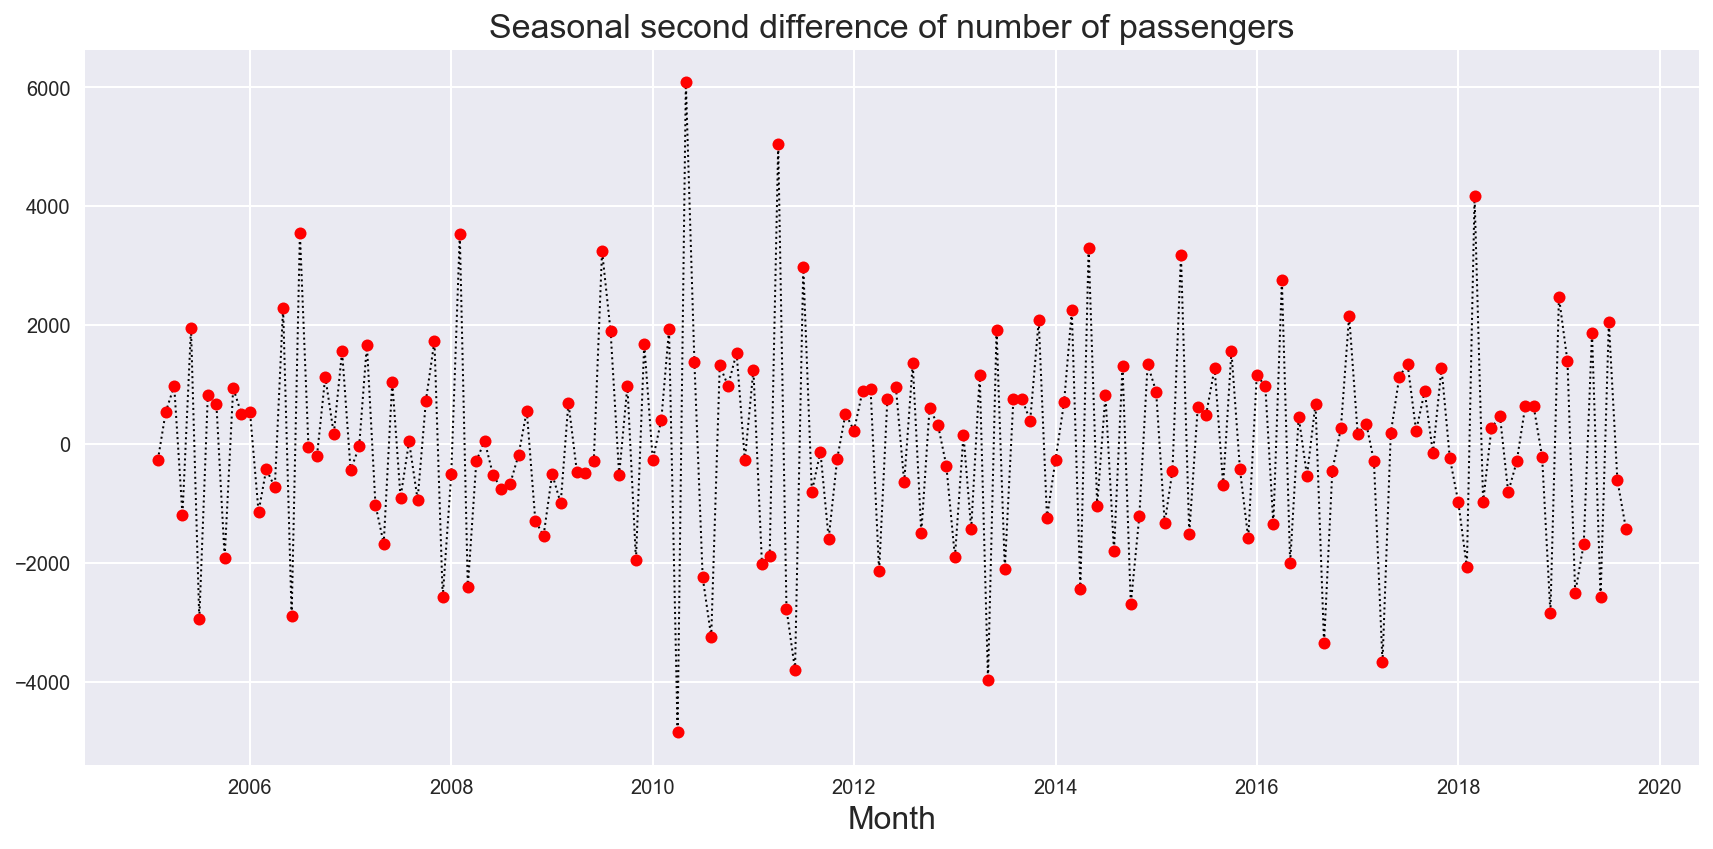

In [55]:
plt.figure(figsize=(12,6))
plt.plot(war_mue['Seasonal second difference'], ls=':', marker='o', markersize=6, lw=1, 
         color='black', markerfacecolor='red')
plt.title('Seasonal second difference of number of passengers', fontdict={'fontsize':17})
plt.xlabel('Month', fontsize=16)
plt.tight_layout()
plt.show()

The stationarity of second difference is also confirmed by the appropriate graph. The second difference leaves no doubt that mean, variance, autocorrelation are constant over time.

In [56]:
model_second_diffrence = auto_arima(
    y=war_mue['Passengers'], 
    start_p=0, max_p=3, 
    start_q=0, max_q=3, 
    m=12,
    start_P=0, 
    seasonal=True, 
    d=2, 
    D=2, 
    trace=False, 
    suppress_warnings=True,
    n_jobs=-1)

model_second_diffrence.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  189
Model:             SARIMAX(2, 2, 1)x(1, 2, 1, 12)   Log Likelihood               -1439.099
Date:                            Mon, 01 Jun 2020   AIC                           2892.198
Time:                                    08:38:15   BIC                           2913.855
Sample:                                         0   HQIC                          2900.991
                                            - 189                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.0792      1.500     -0.719      0.472      -4.020       1.862
ar.L1         -0.4256      0.078     -5.473      0.000      -0.578      -0.273
ar.L2         -0.1885      0.097     -1.951      0.051      -0.378       0.001
ma.L1         -0.9981      0.470     -2.121      0.034      -1.920      -0.076
ar.S.L12      -0.3990      0.087     -4.594      0.000      -0.569      -0.229
ma.S.L12      -0.9767      0.486     -2.008      0.045      -1.930      -0.024
sigma2      2.217e+06    7.9e-07   2.81e+12      0.000    2.22e+06    2.22e+06
===================================================================================
Ljung-Box (Q):                       35.37   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.68   Prob(JB):                         0.97
Heteroskedasticity (H):               0.69   Skew:                             0.01
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.8e+28. Standard errors may be unstable.
"""

As above, the auto arima model is searching for the best parameters. The best model found is characterized by the parameters of order = (2, 2, 1) and seasonal order = (1, 2, 1, 12). Akaike criterion is 2892.198.

However, AIC score alone do not say much about the quality of predictive models. On this basis, it seems that the model based on the second differences is slightly better, but the difference itself seems small and insignificant. Accurate assessment of models requires comparison by their predictive value.

In [57]:
len(war_mue)

189

In [58]:
train_set = war_mue.iloc[:165]
test_set = war_mue.iloc[165:]

The time series is divided into training and testing part.

In [59]:
model_first_difference = SARIMAX(
    train_set['Passengers'], 
    order=(0,1,1), 
    seasonal_order=(0,1,1,12),
    freq='MS').fit()

model_second_difference = SARIMAX(
    train_set['Passengers'], 
    order=(2,2,1), 
    seasonal_order=(1,2,1,12),
    freq='MS').fit()

Two SARIMAX models are created based on the training set and previously found parameters. The models differ from each other in that one of them is prepared based on the first differences and the other based on the second differences.

In [60]:
start = len(train_set)
end = len(train_set) + len(test_set) - 1

test_pred_first = model_first_difference.predict(start=start, end=end)
test_pred_second = model_second_difference.predict(start=start, end=end)

In [61]:
print('Root mean squared error for model with first difference: {:.3f}'.
      format(np.sqrt(mean_squared_error(test_set['Passengers'], test_pred_first))))

print('Root mean squared error for model with second difference: {:.3f}'.
      format(np.sqrt(mean_squared_error(test_set['Passengers'], test_pred_second))))

Root mean squared error for model with first difference: 2215.300
Root mean squared error for model with second difference: 1296.225


Comparison of models through the RMSE value indicates a significant advantage of the model based on the second differences. The error is almost two times smaller.

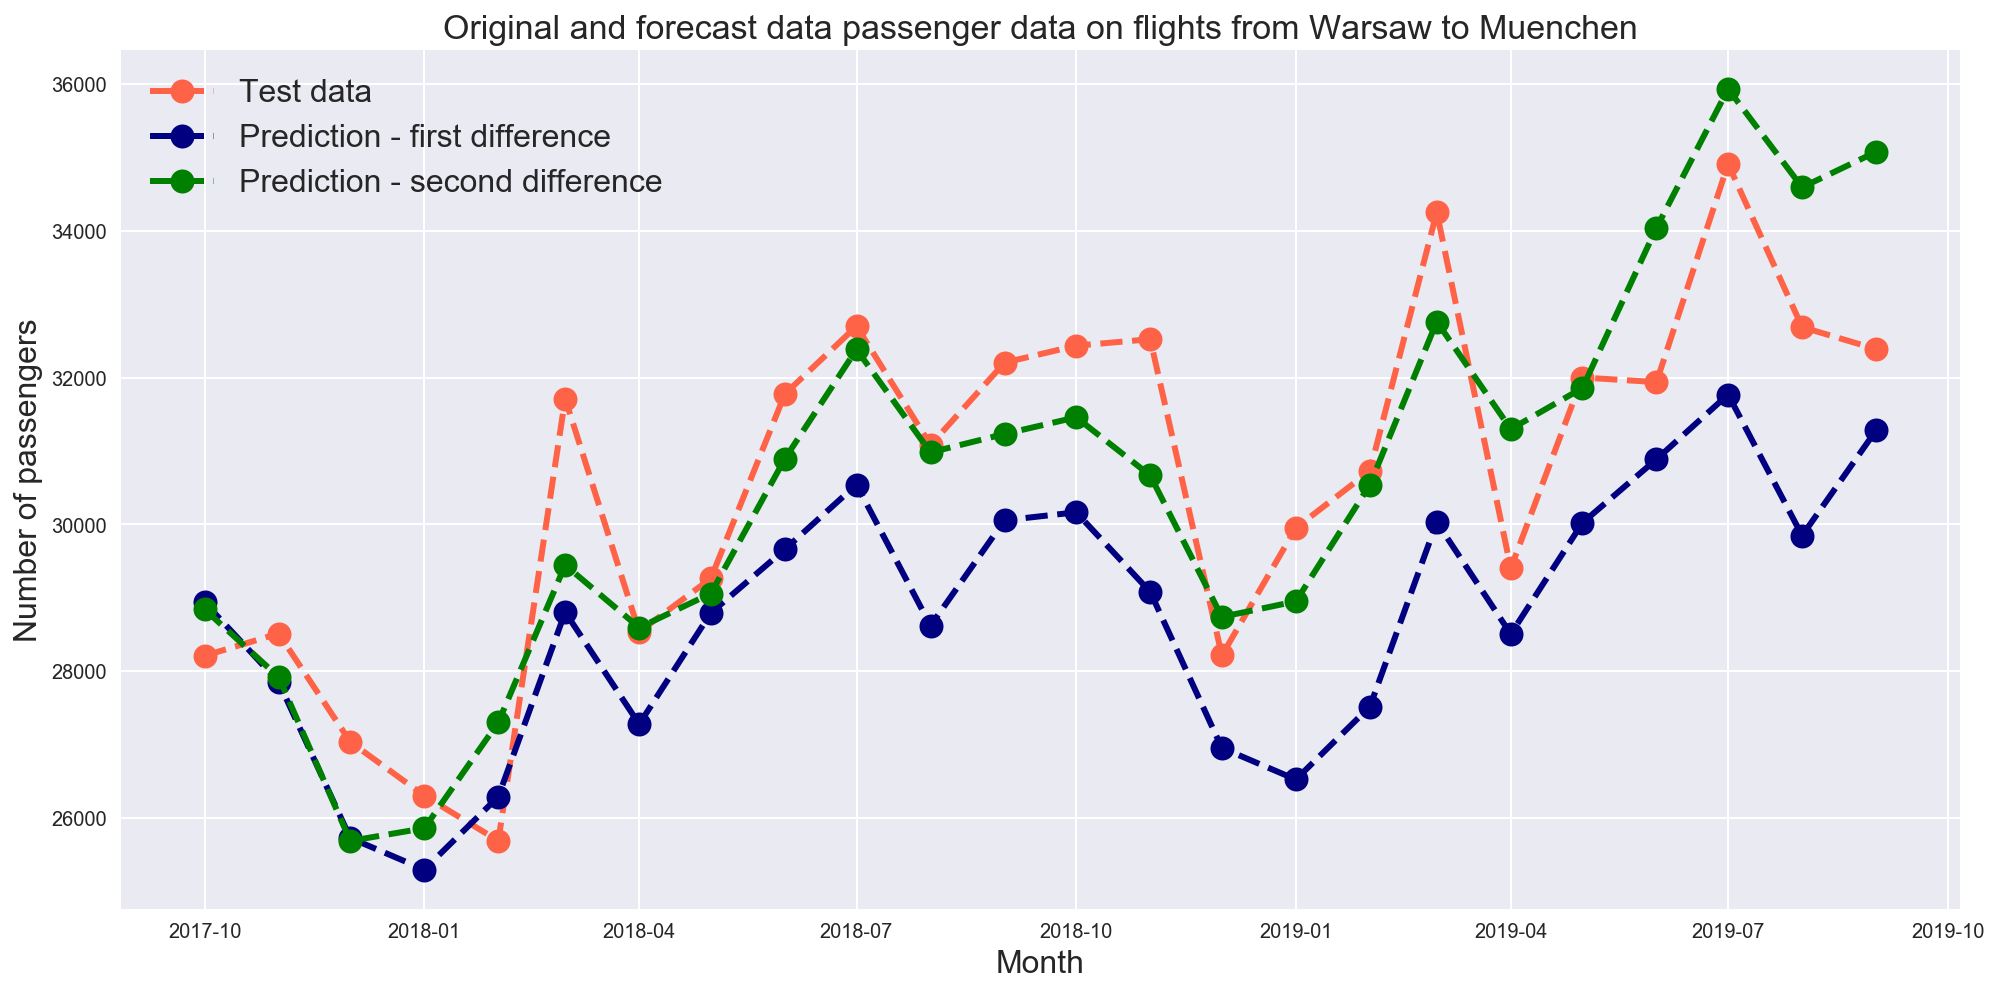

In [62]:
plt.figure(figsize=(14,7))

plt.plot(test_set['Passengers'], color='tomato', lw=3, ls='--', 
         label='Test data', marker='o', markersize=12)
plt.plot(test_pred_first, color='navy', lw=3, ls='--',
         label='Prediction - first difference', marker='o', markersize=12)
plt.plot(test_pred_second, color='green', lw=3, ls='--',
         label='Prediction - second difference', marker='o', markersize=12)

plt.legend(loc='upper left', prop={'size':16})
plt.title('Original and forecast data passenger data on flights from Warsaw to Muenchen', 
          fontdict={'fontsize':17})
plt.xlabel('Month', fontsize=16)
plt.ylabel('Number of passengers', fontsize=16)
plt.tight_layout()
plt.show()

The above is also confirmed visually by the graph. The prediction made by the model created on the basis of the second differences (in green) is definitely closer to the original values (in orange) than the competitive model (in blue).

In [63]:
model = SARIMAX(
    war_mue['Passengers'], 
    order=(0,2,2), 
    seasonal_order=(1,2,1,12),
    freq='MS').fit()

With the better model already chosen, the final model is prepared based on the **entire** time series and parameters of the model based on the second differences.

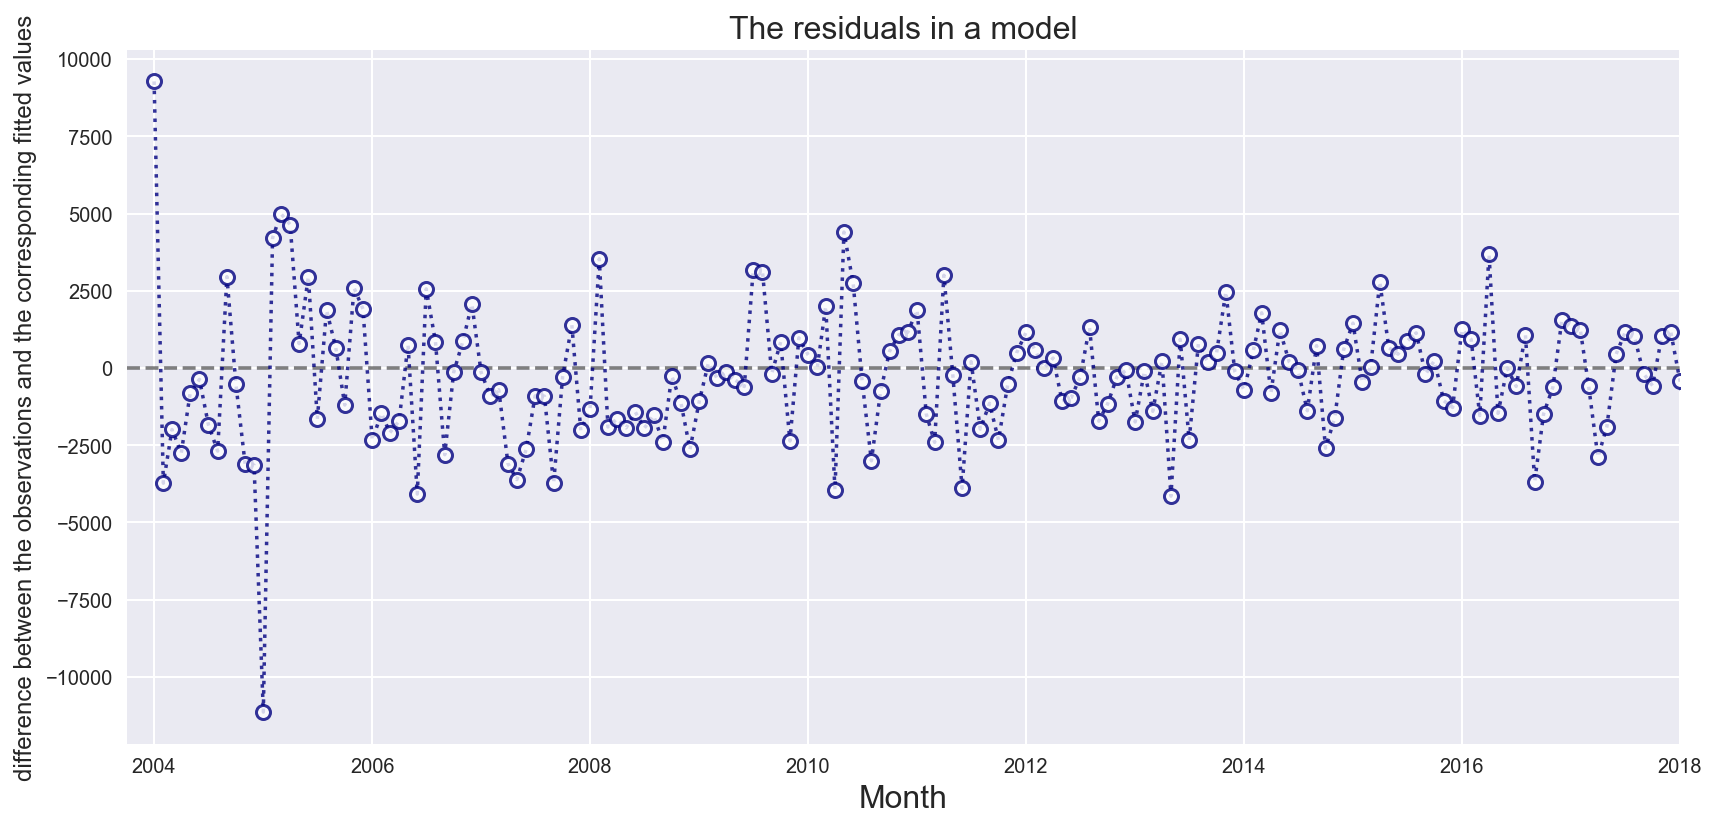

In [64]:
plt.figure(figsize=(12,6))
plt.plot(model.resid, color='navy', marker='o', ls=':', alpha=0.8, markerfacecolor='white',
        markeredgecolor='navy', markeredgewidth=1.5)
plt.hlines(0, '2003-10-01', '2018-01-01', ls='--', alpha=.5)
plt.xlim('2003-10-01', '2018-01-01')
plt.title('The residuals in a model', size=16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('difference between the observations and the corresponding fitted values', size=12)
plt.tight_layout()
plt.show()

The residuals in a time series model are what is left over after fitting a model. As can be seen in the graph above, the fit seems good enough, the mean of residuals seems to be close to zero. Hence, the model seems to be fit.

The prediction of the final model is presented below. Unfortunately, it is not possible to check the accuracy of this prediction, as it is an unknown future.

In [65]:
#predicting values for the next 2 years
pred = model.predict(start=len(war_mue), end=len(war_mue)+24)
pred.head()

2019-10-01    33139.869395
2019-11-01    33535.863975
2019-12-01    30121.966788
2020-01-01    30900.486365
2020-02-01    31109.167412
Freq: MS, dtype: float64

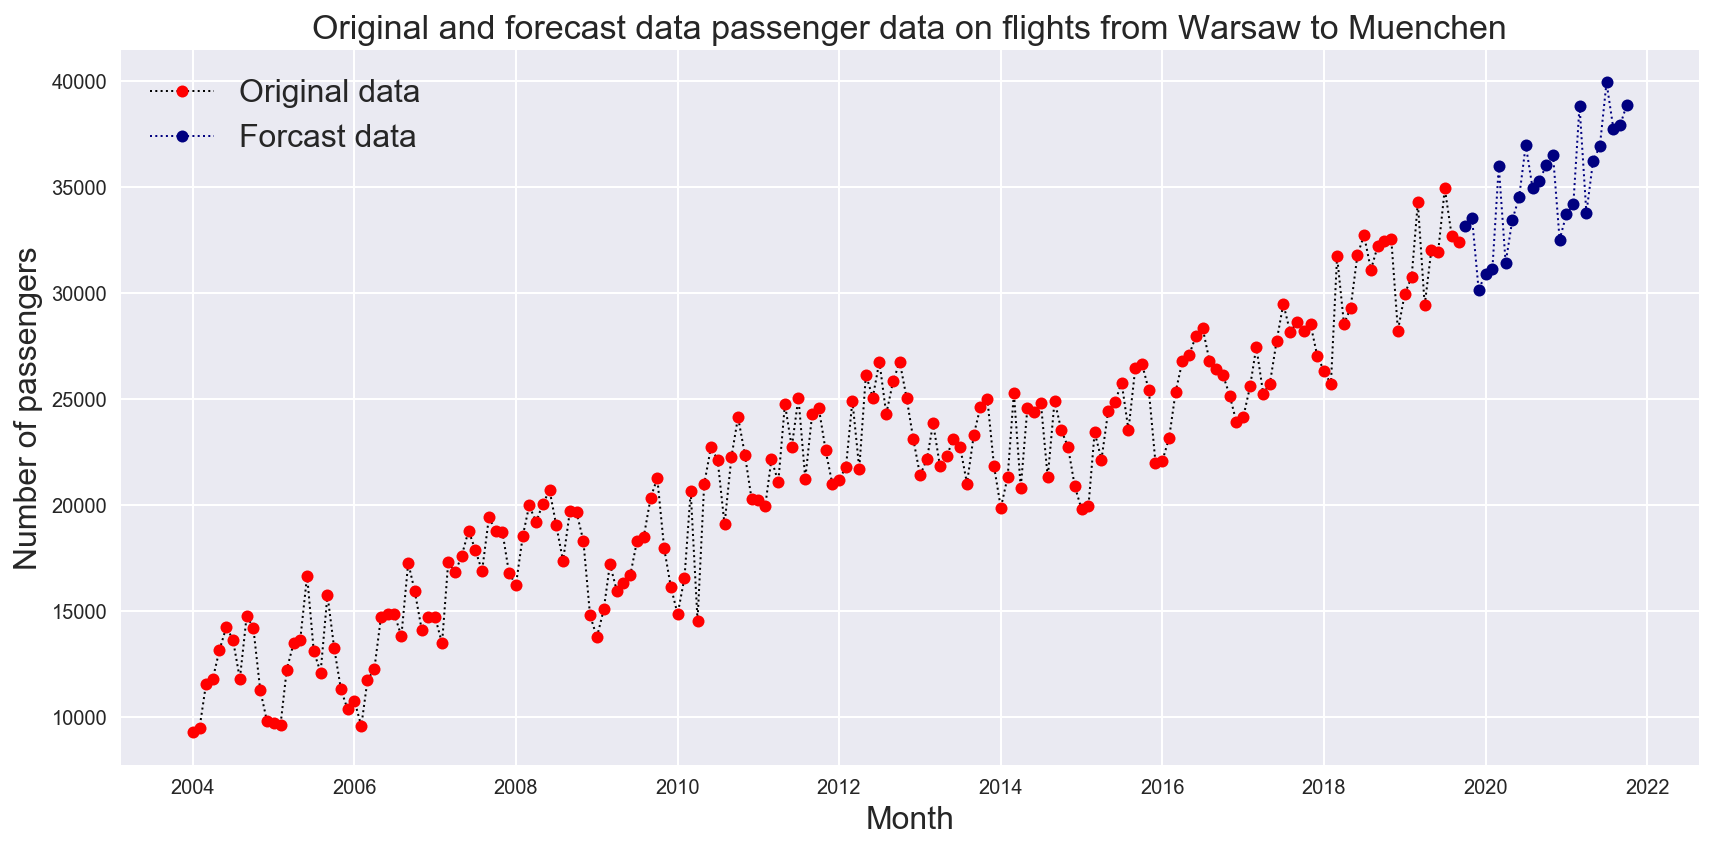

In [66]:
plt.figure(figsize=(12,6))
plt.plot(war_mue['Passengers'], ls=':', marker='o', markersize=6, lw=1, 
         color='black', markerfacecolor='red', label='Original data')
plt.plot(pred, ls=':', marker='o', markersize=6, lw=1, 
         color='navy', markerfacecolor='navy', label='Forcast data')
plt.legend(loc='upper left', prop={'size':16})
plt.title('Original and forecast data passenger data on flights from Warsaw to Muenchen', 
          fontdict={'fontsize':17})
plt.xlabel('Month', fontsize=16)
plt.ylabel('Number of passengers', fontsize=16)
plt.tight_layout()
plt.show()

# Thank you very much! :)